Project 2

Start date: March 4 2025

Machine learning experiments

In [1]:
import optuna
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
from collections import defaultdict, Counter
from math import ceil

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, ClusterCentroids, NearMiss, EditedNearestNeighbours
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, balanced_accuracy_score, f1_score, average_precision_score 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

from lazypredict.Supervised import LazyClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn import tree
from sklearn.ensemble import ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC


d:\Installations\Python\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
seed = random.randint(1000, 9999)
seed = 3543 #2851 # 
np.random.seed(seed)
random.seed(seed)
print(seed)

3543


In [4]:
## Load data
df = pd.read_csv('data/term-deposit-marketing-2020.csv')

In [5]:
df.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


### Model 1

In [6]:
# Select demographic and financial fields
df_model1 = df.copy()
df_model1 = df.drop(columns=["contact", "day", "month", "duration", "campaign"])

# Apply Label Encoding to binary categorical features
binary_features = ["default", "housing", "loan", "y"]
label_encoders = {}
for col in binary_features:
    label_encoders[col] = LabelEncoder()
    df_model1[col] = label_encoders[col].fit_transform(df_model1[col])

# Apply One-Hot Encoding to multi-class categorical features
multi_class_features = ["job", "marital", "education"]
df_model1 = pd.get_dummies(df_model1, columns=multi_class_features, drop_first=True)

# Display the transformed dataset
df_model1.head()

,age,default,balance,housing,loan,y,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown
0,58,0,2143,1,0,0,False,False,False,True,...,False,False,False,False,False,True,False,False,True,False
1,44,0,29,1,0,0,False,False,False,False,...,False,False,True,False,False,False,True,True,False,False
2,33,0,2,1,1,0,False,True,False,False,...,False,False,False,False,False,True,False,True,False,False
3,47,0,1506,1,0,0,True,False,False,False,...,False,False,False,False,False,True,False,False,False,True
4,33,0,1,0,0,0,False,False,False,False,...,False,False,False,False,True,False,True,False,False,True


x_train shape:  (32000, 21)
y_train shape:  (32000,)
x_test shape:  (8000, 21)
y_test shape:  (8000,)


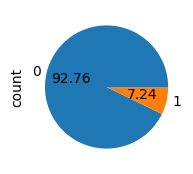

In [7]:
# Separate features and target variable
X = df_model1.drop(columns=["y"])
y = df_model1["y"]

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

# Numerical features for scaling
numerical_features = ["age", "balance"]

# Apply Standard Scaling to numerical features
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# Display the prepared training set
#X_train.head(3), y_train.head(3)

print('x_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('x_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

plt.figure(figsize=(2, 2))
y_train.value_counts().plot.pie(autopct='%.2f')
plt.show()

In [8]:
# ## Running LazyPredict multiple times to assess stability of the models
# # Number of iterations
# num_iterations = 50

# # Dictionary to store top 10 models per iteration
# top_models_per_iteration = []

# # Dictionary to store best accuracy and corresponding seed for each model
# best_seeds = defaultdict(lambda: (0, None))

# for _ in range(num_iterations):
#     # Split data with different random seed
#     seed = random.randint(1000, 9999)
#     x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    
#     # Initialize LazyClassifier
#     clf = LazyClassifier(verbose=0, predictions=False,ignore_warnings=True, custom_metric=recall_score,)
    
#     # Fit and evaluate models
#     models, _ = clf.fit(x_train, x_test, y_train, y_test)
    
#     # Get top 10 models for this iteration
#     top_10_models = models.head(5).index.tolist()
#     top_models_per_iteration.extend(top_10_models)
    
#     # Record best accuracy and corresponding seed
#     for model_name, row in models.iterrows():
#         accuracy = row['recall_score']
#         if accuracy > best_seeds[model_name][0]:
#             best_seeds[model_name] = (accuracy, seed)

# # Count occurrences of each model in the top 10
# model_counts = Counter(top_models_per_iteration)

# # Get the three most frequently appearing models
# best_models = model_counts.most_common(3)

# # Display results
# print("Top 3 Most Frequently Appearing Models in Top 5:")
# for model, count in best_models:
#     best_accuracy, best_seed = best_seeds[model]
#     print(f"{model}: {count} times, Best Accuracy: {best_accuracy:.4f}, Best Seed: {best_seed}")


In [9]:

# def custom_recall_precision(y_true, y_pred):
#     recall = recall_score(y_true, y_pred) #, average='weighted') # Or appropriate averaging
#     precision = precision_score(y_true, y_pred) #, average='weighted', zero_division=0) # Or appropriate averaging
#     return (ceil(recall * 100) / 100, ceil(precision * 100) / 100) # Or {'recall': recall, 'precision': precision}

# clf = LazyClassifier(verbose=-1,ignore_warnings=True, predictions=True, random_state=seed, custom_metric=recall_score)
# models,predictions = clf.fit(X_train, X_test, y_train, y_test)

# models

How to select the best model?

We can't use accuracy because the dataset is imbalanced.
Balanced accuracy = average recall (true positive rate) calculated separately for each class. This is more suitable when the data is imbalanced. 
We can used a combination of balanced accuracy, ROC AUC, and F1 score to select top models. F1 score is useful when you care about true positives more than true negatives.

For cases where metrics are equal, we can use model complexity, interpretability and data types to choose the models.
Ex: Tree-based models work well on tasks involving imbalanced dataset.

Initial set of models selected:
1. Nearest centroid - Highest balanced acc and AUC ROC. The simplest model.
2. Random forest - Ensemble bagging model. Could be good for imbalanced data.
3. Decision tree - Simpler and more interpretable than random forest. Can be used with categorical data without encoding. May not perform well with imbalanced data.
4. XGBoost - Complex, but more powerful model that could give best performance after finetuning. Can adjust hyperparameters to handle imbalanced data.

Now, evaluate these models further using cross-validation.

In [10]:
def display_results(model, model_name, X_train, y_train, X_test, y_test):
    
   # model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=0)
    recall = recall_score(y_test, y_pred, pos_label=0)
    metrics = []
    metrics.append([accuracy, recall, precision])

    plt.figure(figsize=(3, 3))
    cm = confusion_matrix(y_test, y_pred)
    s = sns.heatmap(cm, cbar = False, annot=True, cmap='Blues')
    s.set_xlabel('Pred')
    s.set_ylabel('True')
    s.set_title(model_name)

    metrics_df = pd.DataFrame(metrics, columns=['Accuracy', 'Recall', 'Precision'])
    print(metrics_df)
    plt.show()

In [11]:
def evaluate_models(classifiers, X_train, y_train, X_test, y_test, preprocessing = [], seed=42, folds=5):
    metrics = []
    cm_all = []
    cm_thresh = []
    cross_val_f1 = []
    cross_val_bAcc = []
    cross_val_aucpr = []
    

    #fig, ax = plt.subplots(1, 4, figsize=(12, 3), constrained_layout=True)

    for idx, (clf_name, clf) in enumerate(classifiers.items()):

        steps =  preprocessing.copy() # otherwise steps gets updated inplace

        model = clf

        # Initialize StratifiedKFold
        cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)

        steps.append(('m', model))

        pipeline = Pipeline(steps=steps)

        # Perform stratified cross-validation and get the scores
        scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1')
        cross_val_f1.append([clf_name] + list(scores) + [scores.mean()])
        scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='balanced_accuracy')
        cross_val_bAcc.append([clf_name] + list(scores) + [scores.mean()])
        scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='average_precision')
        cross_val_aucpr.append([clf_name] + list(scores) + [scores.mean()])

        pipeline.fit(X_train, y_train)

        # Make predictions
        y_pred = pipeline.predict(X_test)

        # y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities of the positive class
        # y_pred_custom = (y_proba >= 0.2).astype(int)  # Apply custom threshold

        accuracy = accuracy_score(y_test, y_pred, normalize=True)
        balanced_acc = balanced_accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1_scr = f1_score(y_test, y_pred)
        pr_auc = average_precision_score(y_test, y_pred)
        # s = sns.heatmap(cm, ax=ax[idx], cbar=False, annot=True, fmt='g', cmap='Blues')
        # s.set_xlabel('Pred')
        # s.set_ylabel('True')
        # s.set_title(clf_name)


        metrics.append([clf_name, accuracy, balanced_acc, recall, precision, f1_scr, pr_auc])
        cm = confusion_matrix(y_test, y_pred)
        cm_all.append(cm)
        
        # cm_custom = confusion_matrix(y_test, y_pred_custom)
        # cm_thresh.append(cm_custom)


    columns = ['Model'] + ['Fold' + str(f) for f in range(folds)] + ['Average']
    cross_val_f1_df = pd.DataFrame(cross_val_f1, columns=columns)
    cross_val_bAcc_df = pd.DataFrame(cross_val_bAcc, columns=columns)
    cross_val_aucpr_df = pd.DataFrame(cross_val_aucpr, columns=columns)
    metrics_df = pd.DataFrame(metrics, columns=['Model', 'Accuracy', 'Balanced Accuracy', 'Recall', 'Precision', 'F1 Score', 'AUC PR'])

    return cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm_all#, cm_thresh

def plot_cross_val_metrics(classifiers, cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm, cm_custom=None):
        
    print('Performance on the test: ')
    # Adjust display options
    pd.set_option('display.width', 1000)  # Increase width
    pd.set_option('display.max_columns', None)  # Show all columns
    print(metrics_df)
    
    fig, ax = plt.subplots(1, len(classifiers), figsize=(3*len(classifiers), 3), constrained_layout=True)
    if len(classifiers) == 1:
        ax = [ax]
    for idx, (clf_name, clf) in enumerate(classifiers.items()):
        s = sns.heatmap(cm[idx], ax=ax[idx], cbar=False, annot=True, fmt='g', cmap='Blues')
        s.set_xlabel('Pred')
        s.set_ylabel('True')
        s.set_title(clf_name)
    fig.suptitle('Test set confusion matrices', fontsize=10)
    plt.show()

    if cm_custom:
        fig, ax = plt.subplots(1, len(classifiers), figsize=(3*len(classifiers), 3), constrained_layout=True)
        for idx, (clf_name, clf) in enumerate(classifiers.items()):
            s = sns.heatmap(cm[idx], ax=ax[idx], cbar=False, annot=True, fmt='g', cmap='Blues')
            s.set_xlabel('Pred')
            s.set_ylabel('True')
            s.set_title(clf_name)
        fig.suptitle('Test set confusion matrices - custom threshold', fontsize=10)
        plt.show()  

    # Plotting the dataframes as barplots
    fig, axes = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)

    # Plot for cross_val_f1_df
    cross_val_f1_df.plot(kind='bar', ax=axes[0], title='F1 Score')
    axes[0].set_xlabel('Model')
    axes[0].set_ylabel('F1 Score')
    axes[0].set_xticklabels(cross_val_f1_df['Model'], rotation=45, ha='right')

    # Plot for cross_val_bAcc_df
    cross_val_bAcc_df.plot(kind='bar', ax=axes[1], title='Balanced Accuracy')
    axes[1].set_xlabel('Model')
    axes[1].set_ylabel('Balanced Accuracy')
    axes[1].set_xticklabels(cross_val_bAcc_df['Model'], rotation=45, ha='right')

    # Plot for cross_val_aucpr_df
    cross_val_aucpr_df.plot(kind='bar', ax=axes[2], title='AUC PR')
    axes[2].set_xlabel('Model')
    axes[2].set_ylabel('AUC PR')
    axes[2].set_xticklabels(cross_val_aucpr_df['Model'], rotation=45, ha='right')
    fig.suptitle('Cross validation metrics on the training set', fontsize=10)
    plt.show()


Performance on the test: 
             Model  Accuracy  Balanced Accuracy  Recall  Precision  F1 Score  AUC PR
0  NearestCentroid      0.61               0.58    0.54       0.10      0.17    0.09
1     DecisionTree      0.87               0.53    0.13       0.13      0.13    0.08
2     RandomForest      0.91               0.52    0.06       0.19      0.09    0.08
3          XGBoost      0.93               0.51    0.02       0.39      0.03    0.08


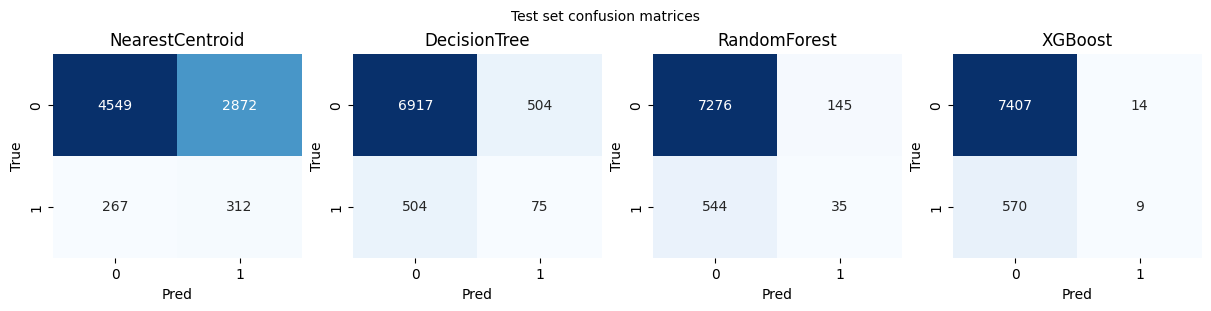

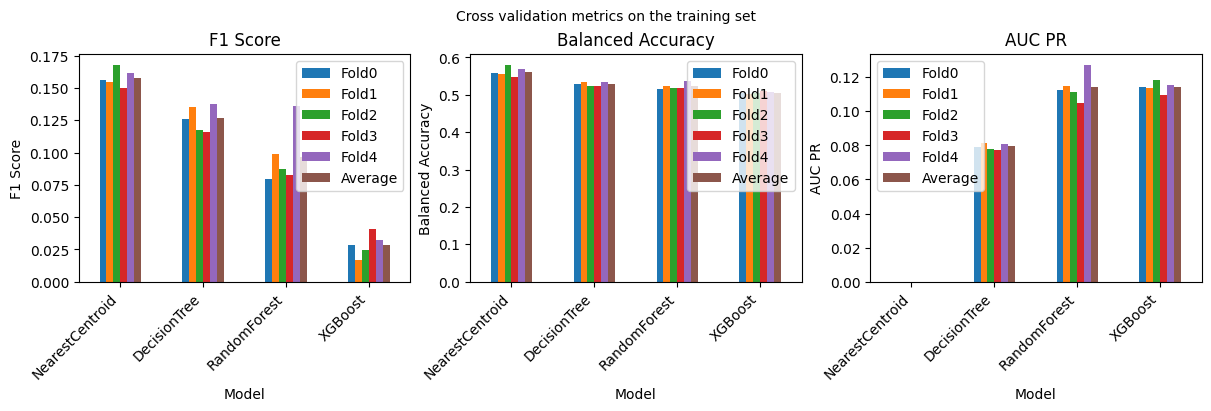

In [12]:
# Re-training the selected models to evaluate consistency with LazyPredict results

classifiers = {
    'NearestCentroid': NearestCentroid(),
    'DecisionTree': DecisionTreeClassifier(random_state=seed),
    'RandomForest': RandomForestClassifier(random_state=seed),
    'XGBoost': XGBClassifier(random_state=seed)
}

cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm = evaluate_models(
    classifiers, X_train, y_train, X_test, y_test, seed=seed)

plot_cross_val_metrics(classifiers, cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm)


Balanced accuracies (of cross validation) are not highly different among models. But, F1 scores are more significantly different.

PR-AUC is a good metric for assessing imbalanced data tasks, especially when we are interested in the positive (often minority) class. PR-AUC shows the opposite variation. NearestCentroid has NaNs probably because it is simple and sensitive to data distributions, thus not classifiying any positives correctly. 
So, we can assume the other three works better with this dataset. We can eliminate nearestCentroid.

### Handling data imbalance
- Data-level (resampling)
- Model-level 
    - using models that are suitable for imbalanced data (ex: tree-based algorithms) 
    - making the model more robust to class imbalance (adjusting the loss function)
    - combining techniques (undersampling + ensemble: training multiple models for sections of the majority class)
- Metric-level (using suitable evaluation metrics)
    - precision, recall, F1 and AUC precision-recall measure performance with respect to the positive class.
- Tuning decision threshold using predict_proba instead of using predict function.

### Resampling

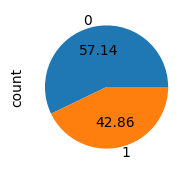

In [ ]:
# Over-sampling
smote = SMOTE(random_state=seed, sampling_strategy=0.75) #sampling_strategy = #minority_samples_after_resampling/#majority_samples
X_train_overSam, y_train_overSam = smote.fit_resample(X_train, y_train)
plt.figure(figsize=(2, 2))
y_train_overSam.value_counts().plot.pie(autopct='%.2f')
plt.show()

In [ ]:
# Under-sampling

# 1. RandomUnderSampler
rus = RandomUnderSampler(random_state=seed, sampling_strategy=0.5)
X_underSam_rus, y_underSam_rus = rus.fit_resample(X_train, y_train)
print("Class distribution after RandomUnderSampler:", pd.Series(y_underSam_rus).value_counts())

# 2. TomekLinks
tl = TomekLinks()
X_underSam_tl, y_underSam_tl = tl.fit_resample(X_train, y_train)
print("Class distribution after TomekLinks:", pd.Series(y_underSam_tl).value_counts())

# 3. ClusterCentroids
cc = ClusterCentroids(random_state=seed, sampling_strategy=0.5)
X_underSam_cc, y_underSam_cc = cc.fit_resample(X_train, y_train)
print("Class distribution after ClusterCentroids:", pd.Series(y_underSam_cc).value_counts())


Class distribution after RandomUnderSampler: y
0    4634
1    2317
Name: count, dtype: int64
Class distribution after TomekLinks: y
0    28618
1     2317
Name: count, dtype: int64
Class distribution after ClusterCentroids: y
0    4634
1    2317
Name: count, dtype: int64


Performance on the test: 
             Model  Accuracy  Balanced Accuracy  Recall  Precision  F1 Score  AUC PR
0  NearestCentroid      0.61               0.57    0.53       0.10      0.16    0.09
1     DecisionTree      0.84               0.52    0.15       0.10      0.12    0.08
2     RandomForest      0.86               0.53    0.16       0.12      0.14    0.08
3          XGBoost      0.91               0.53    0.09       0.22      0.12    0.08


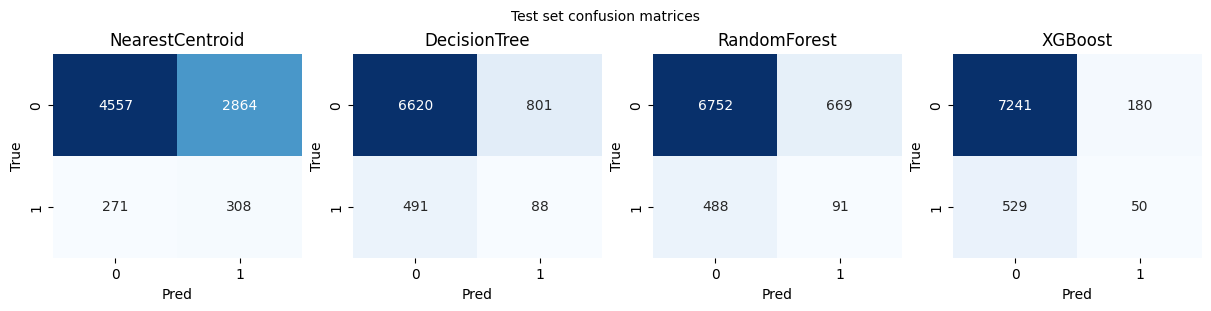

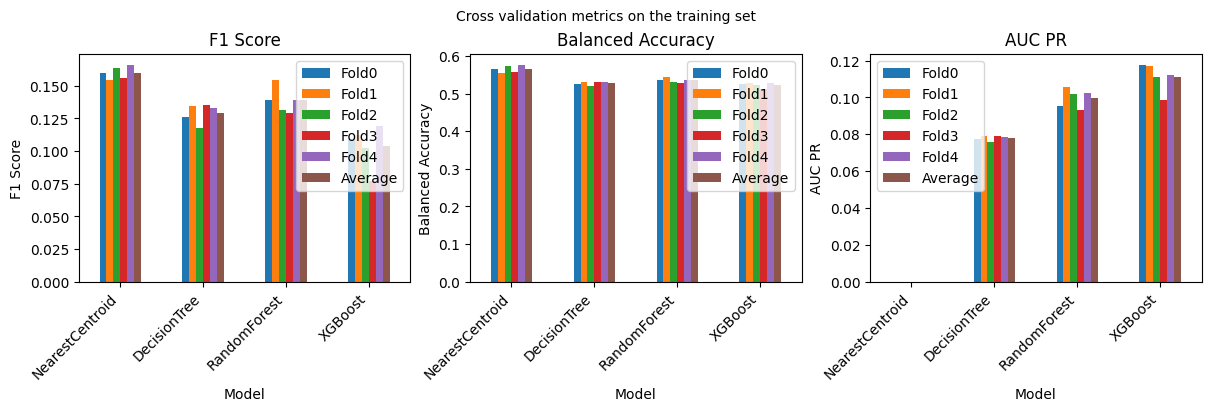

In [ ]:
# Evalutating SMOTE

classifiers = {
    'NearestCentroid': NearestCentroid(),
    'DecisionTree': DecisionTreeClassifier(random_state=seed),
    'RandomForest': RandomForestClassifier(random_state=seed),
    'XGBoost': XGBClassifier(random_state=seed)
}

smote = SMOTE(random_state=seed, sampling_strategy=0.5)
preprocessing = [('r', smote)]

cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm = evaluate_models(
    classifiers, X_train, y_train, X_test, y_test, preprocessing=preprocessing, seed=seed)

plot_cross_val_metrics(classifiers, cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm)

In [ ]:
# Evaluating SMOTE for different sampling ratios

sampling_strategies = [0.1, 0.25, 0.5, 0.75, 1.0]
seed = seed

avg_f1_results = {}
avg_bacc_results = {}
avg_aucpr_results = {}

test_f1 = {}
test_bacc = {}
test_aucpr = {}

for sampling_strategy in sampling_strategies:
    print(f'Sampling ratio: {sampling_strategy}')
    smote = SMOTE(random_state=seed, sampling_strategy=sampling_strategy)
    
    #X_train_overSam, y_train_overSam = smote.fit_resample(X_train, y_train)

    preprocessing = [('r', smote)]

    #cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm = evaluate_models(classifiers, X_train_overSam, y_train_overSam, X_test, y_test, seed=seed)
    cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm = evaluate_models(classifiers, X_train, y_train, X_test, y_test, preprocessing=preprocessing, seed=seed)

    # Store average metrics
    avg_f1_results[sampling_strategy] = cross_val_f1_df[['Model', 'Average']].set_index('Model')['Average'].to_dict()
    avg_bacc_results[sampling_strategy] = cross_val_bAcc_df[['Model', 'Average']].set_index('Model')['Average'].to_dict()
    avg_aucpr_results[sampling_strategy] = cross_val_aucpr_df[['Model', 'Average']].set_index('Model')['Average'].to_dict()

    # Store test metrics
    test_f1[sampling_strategy] = metrics_df[['Model', 'F1 Score']].set_index('Model')['F1 Score'].to_dict()
    test_bacc[sampling_strategy] = metrics_df[['Model', 'Balanced Accuracy']].set_index('Model')['Balanced Accuracy'].to_dict()
    test_aucpr[sampling_strategy] = metrics_df[['Model', 'AUC PR']].set_index('Model')['AUC PR'].to_dict()

    #plot_cross_val_metrics(classifiers, cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm)

# Convert results to DataFrames for plotting
f1_df_plot = pd.DataFrame(avg_f1_results).T
bacc_df_plot = pd.DataFrame(avg_bacc_results).T
aucpr_df_plot = pd.DataFrame(avg_aucpr_results).T
f1_df_plot.index.name = 'Sampling Strategy'
bacc_df_plot.index.name = 'Sampling Strategy'
aucpr_df_plot.index.name = 'Sampling Strategy'

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(12, 3), constrained_layout=True)

f1_df_plot.plot(ax=axes[0], kind='line', title='F1 Score vs. Sampling Strategy')
axes[0].set_ylabel('Average F1 Score')
axes[0].set_xlabel('Sampling Strategy')

bacc_df_plot.plot(ax=axes[1], kind='line', title='Balanced Accuracy vs. Sampling Strategy')
axes[1].set_ylabel('Average Balanced Accuracy')
axes[1].set_xlabel('Sampling Strategy')

aucpr_df_plot.plot(ax=axes[2], kind='line', title='AUC PR vs. Sampling Strategy')
axes[2].set_ylabel('Average AUC PR')
axes[2].set_xlabel('Sampling Strategy')

fig.suptitle('SMOTE Sampling Strategy vs cross validated average metrics', fontsize=12)
plt.show()

# Convert results to DataFrames for plotting
test_f1_df_plot = pd.DataFrame(test_f1).T
test_bacc_df_plot = pd.DataFrame(test_bacc).T
test_aucpr_df_plot = pd.DataFrame(test_aucpr).T
test_f1_df_plot.index.name = 'Sampling Strategy'
test_bacc_df_plot.index.name = 'Sampling Strategy'
test_aucpr_df_plot.index.name = 'Sampling Strategy'

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(12, 3), constrained_layout=True)

test_f1_df_plot.plot(ax=axes[0], kind='line', title='F1 Score vs. Sampling Strategy')
axes[0].set_ylabel('Average F1 Score')
axes[0].set_xlabel('Sampling Strategy')

test_bacc_df_plot.plot(ax=axes[1], kind='line', title='Balanced Accuracy vs. Sampling Strategy')
axes[1].set_ylabel('Average Balanced Accuracy')
axes[1].set_xlabel('Sampling Strategy')

test_aucpr_df_plot.plot(ax=axes[2], kind='line', title='AUC PR vs. Sampling Strategy')
axes[2].set_ylabel('Average AUC PR')
axes[2].set_xlabel('Sampling Strategy')

fig.suptitle('SMOTE Sampling Strategy vs test set metrics', fontsize=12)
plt.show()

Performance on the test: 
             Model  Accuracy  Balanced Accuracy  Recall  Precision  F1 Score  AUC PR
0  NearestCentroid      0.61               0.57    0.53       0.10      0.17    0.09
1     DecisionTree      0.67               0.54    0.39       0.09      0.15    0.08
2     RandomForest      0.77               0.56    0.31       0.11      0.17    0.09
3          XGBoost      0.83               0.56    0.26       0.13      0.18    0.09


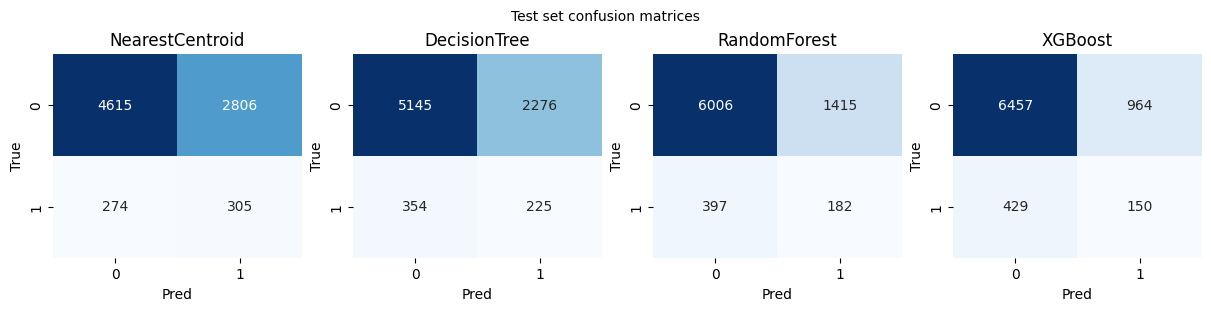

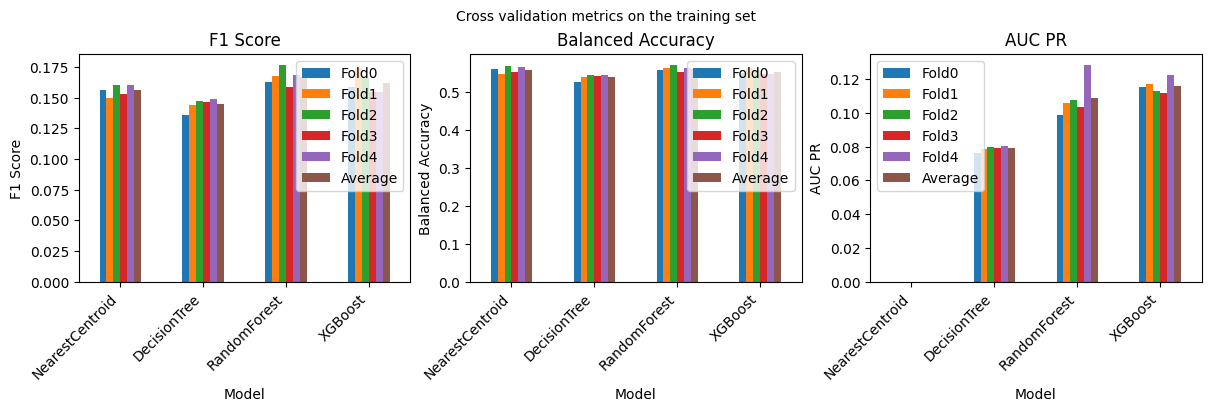

In [ ]:
# Evalutating under sampling

classifiers = {
    'NearestCentroid': NearestCentroid(),
    'DecisionTree': DecisionTreeClassifier(random_state=seed),
    'RandomForest': RandomForestClassifier(random_state=seed),
    'XGBoost': XGBClassifier(random_state=seed)
}

rus = RandomUnderSampler(random_state=seed, sampling_strategy=0.5)
preprocessing = [('u', rus)]

cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm = evaluate_models(
    classifiers, X_train, y_train, X_test, y_test, preprocessing=preprocessing, seed=seed)

plot_cross_val_metrics(classifiers, cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm)

Under-sampling increases the true positives, but also increases false positives. This could be because there are not enough negative data samples to learn the distribution well.

But, what we are trying to do is create a balance between true positives and false positives.

In [ ]:
# Combining under-sampling and over-sampling
# Oversample the minority class and then undersample the majority class

smote = SMOTE(random_state=seed, sampling_strategy=0.5) #sampling_strategy = #minority_samples_after_resampling/#majority_samples
X_train_overSam, y_train_overSam = smote.fit_resample(X_train, y_train)
plt.figure(figsize=(2, 2))
y_train_overSam.value_counts().plot.pie(autopct='%.2f')
plt.show()
print("Class distribution after over sampling:", pd.Series(y_train_overSam).value_counts())

# 1. RandomUnderSampler
rus = RandomUnderSampler(random_state=seed, sampling_strategy=0.5)
X_underSam_rus, y_underSam_rus = rus.fit_resample(X_train_overSam, y_train_overSam)
print("Class distribution after RandomUnderSampler:", pd.Series(y_underSam_rus).value_counts())

# 2. TomekLinks
tl = TomekLinks(sampling_strategy='majority')
X_underSam_tl, y_underSam_tl = tl.fit_resample(X_train_overSam, y_train_overSam)
print("Class distribution after TomekLinks:", pd.Series(y_underSam_tl).value_counts())

# 3. ClusterCentroids
cc = ClusterCentroids(random_state=seed, sampling_strategy=0.5)
X_underSam_cc, y_underSam_cc = cc.fit_resample(X_train_overSam, y_train_overSam)
print("Class distribution after ClusterCentroids:", pd.Series(y_underSam_cc).value_counts())


Performance on the test: 
             Model  Accuracy  Balanced Accuracy  Recall  Precision  F1 Score  AUC PR
0  NearestCentroid      0.61               0.57    0.52       0.10      0.16    0.08
1     DecisionTree      0.83               0.53    0.18       0.11      0.13    0.08
2     RandomForest      0.81               0.55    0.23       0.11      0.15    0.08
3          XGBoost      0.87               0.54    0.16       0.14      0.15    0.08


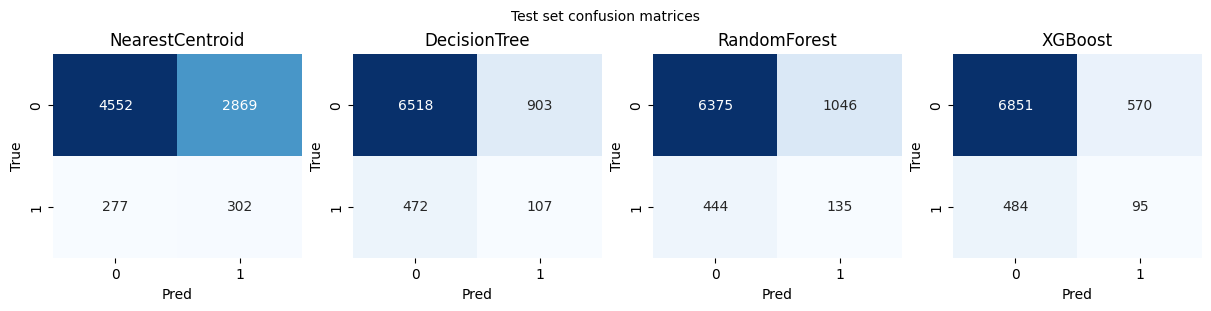

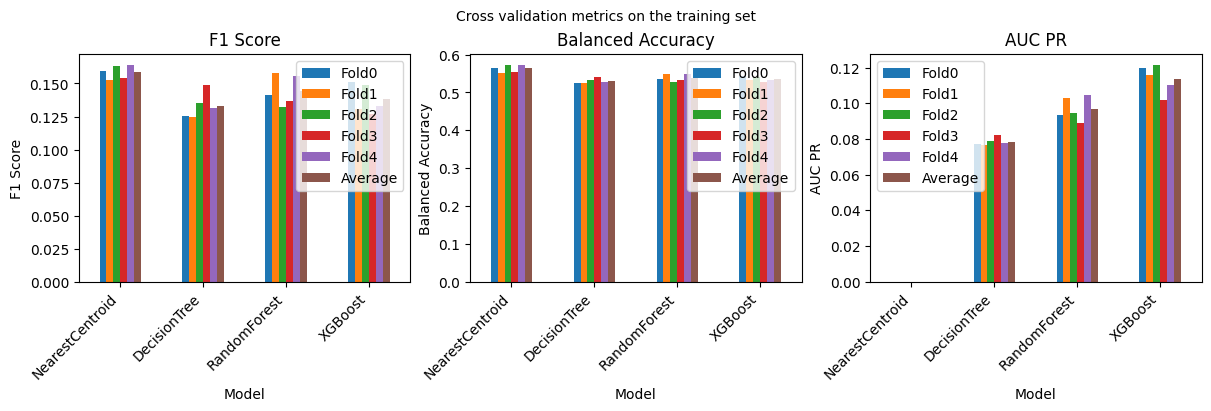

In [ ]:
smote = SMOTE(random_state=seed, sampling_strategy=0.25) 
tomek = TomekLinks(sampling_strategy='majority')
resample = SMOTETomek(random_state=seed)#SMOTETomek(smote=smote, tomek=tomek)
preprocessing = [('r', resample)]
cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm = evaluate_models(
    classifiers, X_train, y_train, X_test, y_test, preprocessing=preprocessing, seed=seed)

plot_cross_val_metrics(classifiers, cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm)

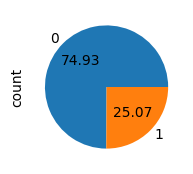

Class distribution after over sampling: y
0    22180
1     7420
Name: count, dtype: int64


In [ ]:
smote = SMOTE(random_state=seed, sampling_strategy=0.25) 
resample = SMOTEENN(smote=smote, enn=EditedNearestNeighbours(sampling_strategy='majority'))
X_train_overSam, y_train_overSam = resample.fit_resample(X_train, y_train)
plt.figure(figsize=(2, 2))
y_train_overSam.value_counts().plot.pie(autopct='%.2f')
plt.show()
print("Class distribution after over sampling:", pd.Series(y_train_overSam).value_counts())

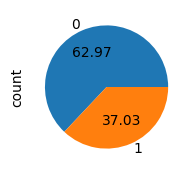

Class distribution after over sampling: y
0    17663
1    10389
Name: count, dtype: int64


In [ ]:
smote = SMOTE(random_state=seed, sampling_strategy=0.35) 
resample = SMOTEENN(smote=smote, enn=EditedNearestNeighbours(sampling_strategy='majority', n_neighbors=5))
X_train_overSam, y_train_overSam = resample.fit_resample(X_train, y_train)
plt.figure(figsize=(2, 2))
y_train_overSam.value_counts().plot.pie(autopct='%.2f')
plt.show()
print("Class distribution after over sampling:", pd.Series(y_train_overSam).value_counts())

Performance on the test: 
             Model  Accuracy  Balanced Accuracy  Recall  Precision  F1 Score  AUC PR
0  NearestCentroid      0.59               0.57    0.55       0.10      0.16    0.09
1     DecisionTree      0.74               0.54    0.30       0.10      0.15    0.08
2     RandomForest      0.72               0.55    0.36       0.10      0.16    0.08
3          XGBoost      0.85               0.56    0.21       0.14      0.17    0.09


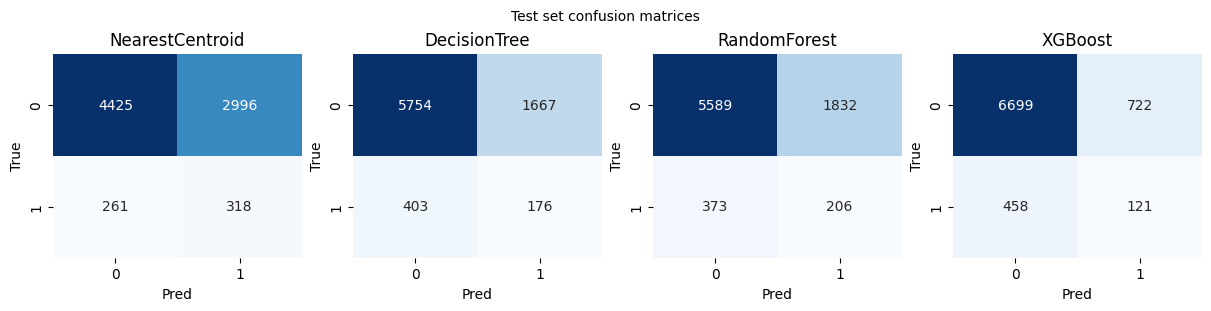

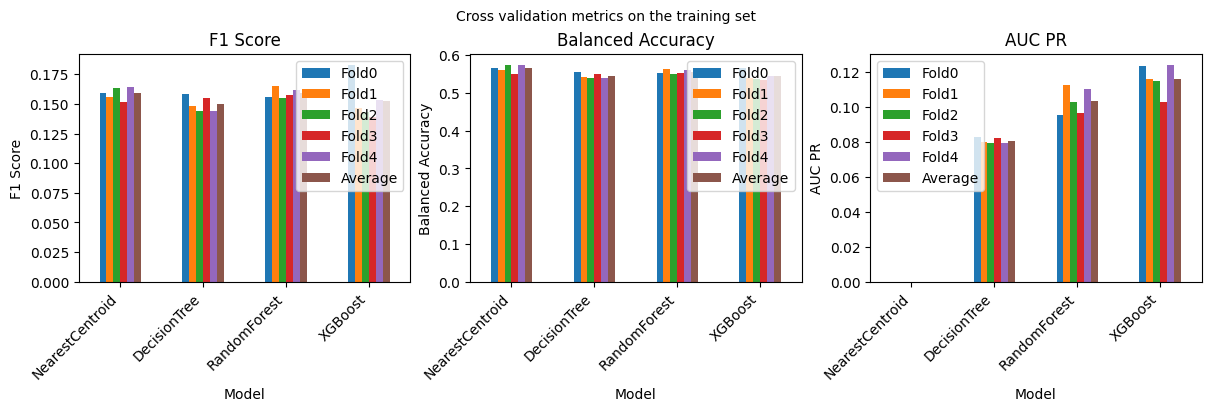

In [ ]:
smote = SMOTE(random_state=seed, sampling_strategy=0.5)
resample = SMOTEENN(smote=smote, enn=EditedNearestNeighbours(sampling_strategy='majority'))
preprocessing = [('r', resample)]
cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm = evaluate_models(
    classifiers, X_train, y_train, X_test, y_test, preprocessing=preprocessing, seed=seed)

plot_cross_val_metrics(classifiers, cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm)

SMOTEENN seem to be the giving the best performance.
Decision tree vs XGBoost: Same true positive rate, while XGBoost shows lower false positive rate. 

One thing to notice: nearestCentroid does not show a large improvement with any of the resampling methods.

### Use class weights and other parameters to manage imbalance
https://medium.com/@ravi.abhinav4/improving-class-imbalance-with-class-weights-in-machine-learning-af072fdd4aa4

Class weights alone may not be suffifient. We may need to combine that with resampling.

NearestCentroid does not have a class_weight option.

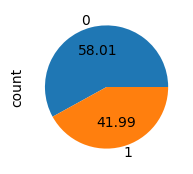

Class distribution after over sampling: y
0    20504
1    14841
Name: count, dtype: int64


In [ ]:
## Resampling before tuning
smote = SMOTE(random_state=seed, sampling_strategy=0.5)
resample = SMOTEENN(smote=smote, enn=EditedNearestNeighbours(sampling_strategy='majority'))
preprocessing = [('r', resample)]
X_train_Sam, y_train_Sam = resample.fit_resample(X_train, y_train)
plt.figure(figsize=(2, 2))
y_train_Sam.value_counts().plot.pie(autopct='%.2f')
plt.show()
print("Class distribution after over sampling:", pd.Series(y_train_Sam).value_counts())

Class distribution after over sampling: y
0    20504
1    14841
Name: count, dtype: int64
Performance on the test: 
           Model  Accuracy  Balanced Accuracy  Recall  Precision  F1 Score  AUC PR
0        xgboost      0.85               0.56    0.21       0.14      0.17    0.09
1  xgboost_tuned      0.81               0.56    0.26       0.12      0.16    0.08


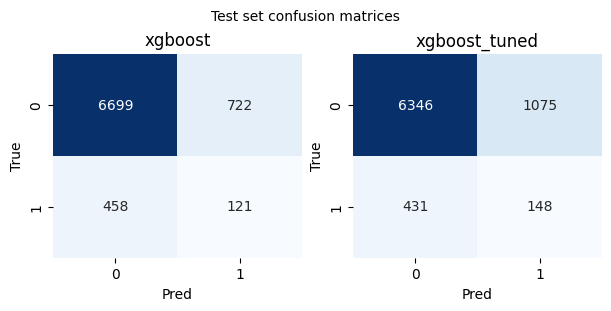

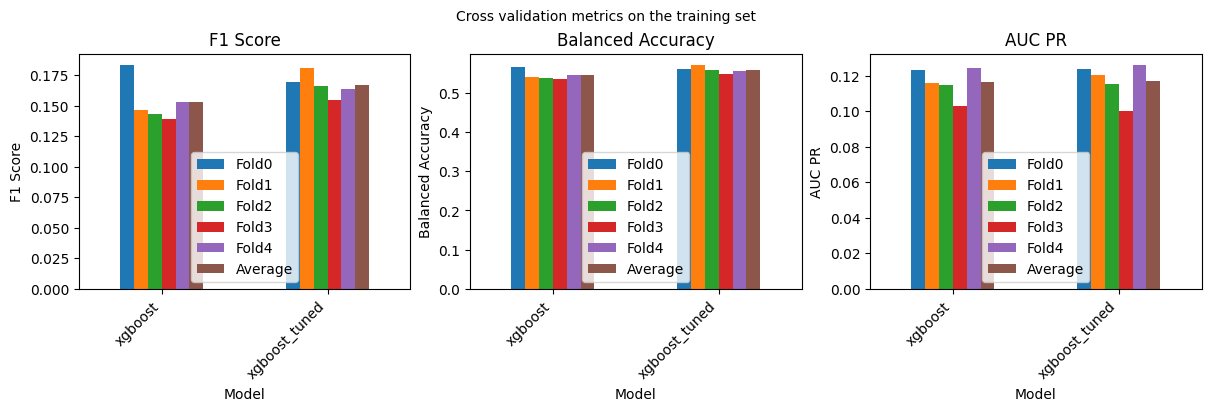

In [ ]:
# pos_frac = y.mean()
# print('pos_frac', pos_frac)

## Resampling before tuning
smote = SMOTE(random_state=seed, sampling_strategy=0.5)
resample = SMOTEENN(smote=smote, enn=EditedNearestNeighbours(sampling_strategy='majority'))
preprocessing = [('r', resample)]
X_train_Sam, y_train_Sam = resample.fit_resample(X_train, y_train)
print("Class distribution after over sampling:", pd.Series(y_train_Sam).value_counts())

counts = y_train_Sam.value_counts()
frac = counts[0]/counts[1]
model_tuned= XGBClassifier(scale_pos_weight=frac, random_state=seed)
model = XGBClassifier(random_state=seed)
classifiers = {'xgboost': model,
              'xgboost_tuned': model_tuned}

cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm = evaluate_models(
    classifiers, X_train, y_train, X_test, y_test, preprocessing=preprocessing, seed=seed)

plot_cross_val_metrics(classifiers, cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm)


In [ ]:
# XGBoost does not use class_weight to add weights to classes. It does this using scale_pos_weight.

## Resampling before tuning
smote = SMOTE(random_state=seed, sampling_strategy=0.25)
resample = SMOTEENN(smote=smote, enn=EditedNearestNeighbours(sampling_strategy='majority'))
preprocessing = [('r', resample)]
X_train_Sam, y_train_Sam = resample.fit_resample(X_train, y_train)
print("Class distribution after over sampling:", pd.Series(y_train_Sam).value_counts())

counts = y_train_Sam.value_counts()
frac = counts[0]/counts[1]

model_tuned= XGBClassifier(scale_pos_weight=frac, random_state=seed)  
model = XGBClassifier(random_state=seed)
classifiers = {'xgboost': model,
              'xgboost_tuned': model_tuned}

cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm = evaluate_models(
    classifiers, X_train, y_train, X_test, y_test, preprocessing=preprocessing, seed=seed)

plot_cross_val_metrics(classifiers, cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm)

Performance on the test: 
                Model  Accuracy  Balanced Accuracy  Recall  Precision  F1 Score  AUC PR
0        randomForest      0.72               0.55    0.36       0.10      0.16    0.08
1  randomForest_tuned      0.73               0.56    0.35       0.10      0.16    0.08


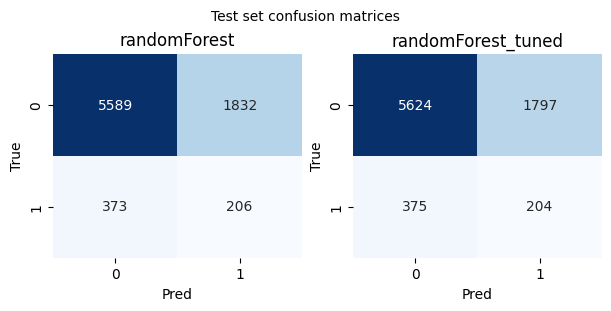

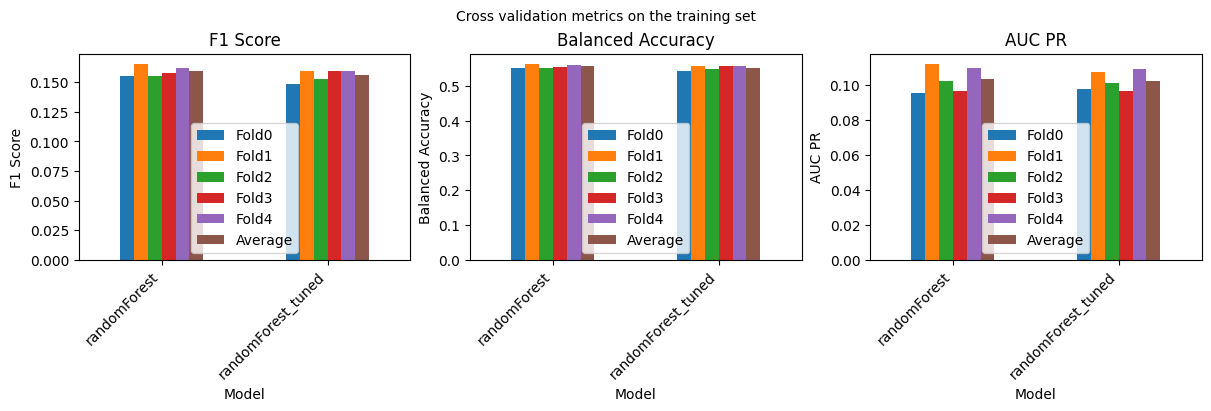

In [ ]:
smote = SMOTE(random_state=seed, sampling_strategy=0.5)
resample = SMOTEENN(smote=smote, enn=EditedNearestNeighbours(sampling_strategy='majority'))
preprocessing = [('r', resample)]

counts = y_train_Sam.value_counts()
total_samples = len(y_train_Sam)
weights = {0: total_samples / (2 * counts[0]), 1: 5 * total_samples / (2 * counts[1])} # increase the weight of the minority class further.

model_tuned= RandomForestClassifier(class_weight='balanced_subsample', random_state=seed)
model = RandomForestClassifier(random_state=seed)
classifiers = {'randomForest': model,
              'randomForest_tuned': model_tuned}

cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm = evaluate_models(
    classifiers, X_train, y_train, X_test, y_test, preprocessing=preprocessing, seed=seed)

plot_cross_val_metrics(classifiers, cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm)

In [ ]:
weights

{0: 0.8619049941474834, 1: 5.953945151943939}

Playing around with the class_weights does not have a huge impact on performance for random forest.

Even when the weights for class 1 were aggressively increased, there was no significant improvement.

Performance on the test: 
                Model  Accuracy  Balanced Accuracy  Recall  Precision  F1 Score  AUC PR
0        randomForest      0.80               0.56    0.27       0.12      0.16    0.08
1  randomForest_tuned      0.80               0.56    0.27       0.12      0.16    0.08


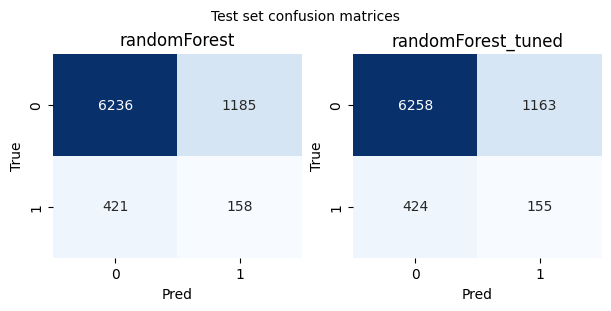

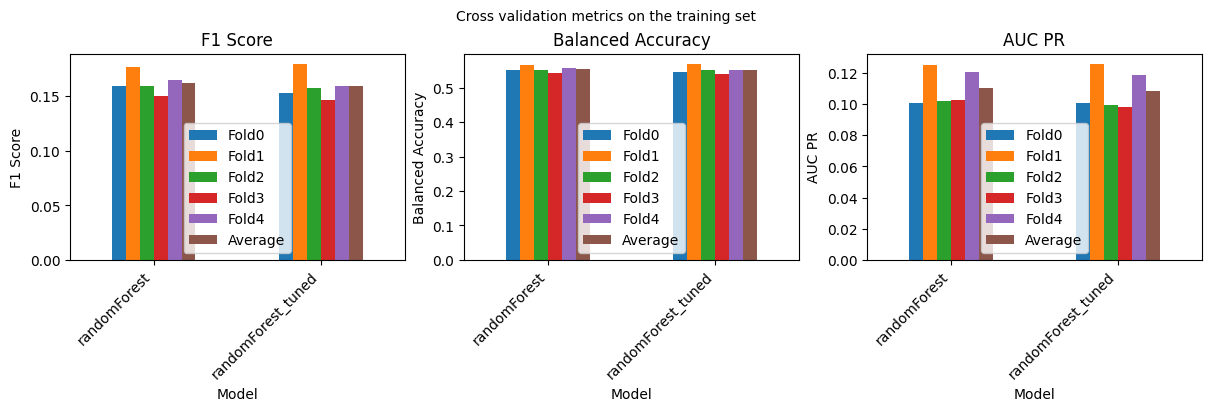

In [ ]:


smote = SMOTE(random_state=seed, sampling_strategy=0.25)
resample = SMOTEENN(smote=smote, enn=EditedNearestNeighbours(sampling_strategy='majority'))
preprocessing = [('r', resample)]

counts = y_train_Sam.value_counts()
total_samples = len(y_train_Sam)
weights = {0: total_samples / (2 * counts[0]), 1: 5 * total_samples / (2 * counts[1])} # increase the weight of the minority class further.

model_tuned= RandomForestClassifier(class_weight=weights, random_state=seed)
model = RandomForestClassifier(random_state=seed)
classifiers = {'randomForest': model,
              'randomForest_tuned': model_tuned}

cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm = evaluate_models(
    classifiers, X_train, y_train, X_test, y_test, preprocessing=preprocessing, seed=seed)

plot_cross_val_metrics(classifiers, cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm)

In [ ]:
smote = SMOTE(random_state=seed, sampling_strategy=0.5)
resample = SMOTEENN(smote=smote, enn=EditedNearestNeighbours(sampling_strategy='majority'))
preprocessing = [('r', resample)]

model_tuned= DecisionTreeClassifier(class_weight='balanced', random_state=seed)
model = DecisionTreeClassifier(random_state=seed)
classifiers = {'decisionTree': model,
              'decisionTree_tuned': model_tuned}

cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm = evaluate_models(
    classifiers, X_train, y_train, X_test, y_test, preprocessing=preprocessing, seed=seed)

plot_cross_val_metrics(classifiers, cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm)

Aggressively increasing weighting for class 1 decreased true positives.

Only XGBoost seem to be showing a positive improvement with class weights. Do the other two classifiers require threshold tuning?

In [ ]:
smote = SMOTE(random_state=seed, sampling_strategy=0.25)
resample = SMOTEENN(smote=smote, enn=EditedNearestNeighbours(sampling_strategy='majority'))
preprocessing = [('r', resample)]

counts = y_train_Sam.value_counts()
total_samples = len(y_train_Sam)
weights = {0: total_samples / (2 * counts[0]), 1: 5 * total_samples / (2 * counts[1])} # increase the weight of the minority class further.

model_tuned= DecisionTreeClassifier(class_weight=weights, random_state=seed)
model = DecisionTreeClassifier(random_state=seed)
classifiers = {'decisionTree': model,
              'decisionTree_tuned': model_tuned}

cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm = evaluate_models(
    classifiers, X_train, y_train, X_test, y_test, preprocessing=preprocessing, seed=seed)

plot_cross_val_metrics(classifiers, cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm)

### Tune hyperparameters using Optuna

In [ ]:
def hyper_param_tuning(model, resampling, params):

    # Objective function for Optuna
    def objective(trial):
        params = params

        # Applying resampling
        pipeline = Pipeline(steps=[('r', resampling),('m', model)])

        # Using StratifiedKFold to ensure class balance in each fold
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

        scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='average_precision', n_jobs=-1)

        return np.mean(scores)
    

    # Run Optuna optimization
    study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=seed))
    study.optimize(objective, n_trials=100)

    # Best hyperparameters
    print("Best parameters:", study.best_params)

In [ ]:
## Resampling before tuning
smote = SMOTE(random_state=seed, sampling_strategy=0.25)
resample = SMOTEENN(smote=smote, enn=EditedNearestNeighbours(sampling_strategy='majority'))
preprocessing = [('r', resample)]
X_train_Sam, y_train_Sam = resample.fit_resample(X_train, y_train)


# Objective function for Optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10)  # Important for imbalanced data
    }

    model = XGBClassifier(
        objective='binary:logistic', **params, random_state=seed, #aucpr
    ) 

    # Applying resampling
    pipeline = Pipeline(steps=[('r', resample),('m', model)])

    # Using StratifiedKFold to ensure class balance in each fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

    scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='average_precision', n_jobs=1) #average_precision

    return np.mean(scores)

# Run Optuna optimization
study_xgboost = optuna.create_study(direction='maximize', sampler=optuna.samplers.NSGAIISampler())
study_xgboost.optimize(objective, n_trials=100)

# Best hyperparameters
print("Best parameters:", study_xgboost.best_params)

[I 2025-04-05 17:50:39,034] A new study created in memory with name: no-name-98122c5b-7e19-435d-b41f-a9d55369f521
[I 2025-04-05 17:50:47,744] Trial 0 finished with value: 0.1333949957286133 and parameters: {'n_estimators': 400, 'max_depth': 4, 'learning_rate': 0.032869255773293735, 'subsample': 0.6800045741093214, 'colsample_bytree': 0.9098761018760466, 'gamma': 1.3220410425559987, 'reg_alpha': 2.101805441128297, 'reg_lambda': 8.918549796302093, 'scale_pos_weight': 3.5891604531996535}. Best is trial 0 with value: 0.1333949957286133.
[W 2025-04-05 17:50:56,271] Trial 1 failed with parameters: {'n_estimators': 400, 'max_depth': 12, 'learning_rate': 0.11017768936029976, 'subsample': 0.8427598343832432, 'colsample_bytree': 0.7123571107235778, 'gamma': 0.7457345165120116, 'reg_alpha': 7.440560634615968, 'reg_lambda': 9.531120064408709, 'scale_pos_weight': 9.80367527240982} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "d:\Installations\Python

KeyboardInterrupt: 

In [ ]:
#print("Best parameters:", study_xgboost.best_params)
## Recall
study_xgboost.best_params

In [ ]:
## F1
study_xgboost.best_params

In [ ]:
## Balanced Acc
study_xgboost.best_params

In [ ]:
# XGBoost does not use class_weight to add weights to classes. It does this using scale_pos_weight.

best_params_xgboost = study_xgboost.best_params#{'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.01013744361125413, 'subsample': 0.9574559811784255, 'colsample_bytree': 0.6195836688112757, 'gamma': 4.785334898375495, 'reg_alpha': 0.636035876647475, 'reg_lambda': 8.817908204330237, 'scale_pos_weight': 5.124206670548994}

## Resampling before tuning
smote = SMOTE(random_state=seed, sampling_strategy=0.25)
resample = SMOTEENN(smote=smote, enn=EditedNearestNeighbours(sampling_strategy='majority'))
preprocessing = [('r', resample)]
X_train_Sam, y_train_Sam = resample.fit_resample(X_train, y_train)
print("Class distribution after over sampling:", pd.Series(y_train_Sam).value_counts())

model_tuned= XGBClassifier(**best_params_xgboost, random_state=seed)  
model = XGBClassifier(random_state=seed) #eval_metric='aucpr'
classifiers = {'xgboost': model,
              'xgboost_tuned': model_tuned}

cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm = evaluate_models(
    classifiers, X_train, y_train, X_test, y_test, preprocessing=preprocessing, seed=seed)

plot_cross_val_metrics(classifiers, cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm)

Tuning XGBoost using recall leads to 568 true positives, while 7180 false positives. So, almost all negatives were categorized as positive. So, that classifier is not useful.
Upto now, best model was obtained using pr_auc as the cross validation metric.

In [ ]:
def objective(trial):
    """ Objective function for tuning Decision Tree Classifier """
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced'])
    }

    model = DecisionTreeClassifier(**params, random_state=seed)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

     # Applying resampling
    pipeline = Pipeline(steps=[('r', resample),('m', model)])
    
    scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='recall', n_jobs=1)

    return np.mean(scores)

# Run Optuna optimization
study_DT = optuna.create_study(direction='maximize', sampler=optuna.samplers.NSGAIISampler(seed=seed))
study_DT.optimize(objective, n_trials=100)

# Best hyperparameters
print("Best parameters:", study_DT.best_params)

In [ ]:
study.best_params

In [ ]:
study_DT.best_params

In [ ]:
best_params_DT = {'max_depth': 3,
 'min_samples_split': 2,
 'min_samples_leaf': 5,
 'criterion': 'entropy',
 'class_weight': 'balanced'}

smote = SMOTE(random_state=seed, sampling_strategy=0.25)
resample = SMOTEENN(smote=smote, enn=EditedNearestNeighbours(sampling_strategy='majority'))
preprocessing = [('r', resample)]

model_tuned= DecisionTreeClassifier(**best_params_DT, random_state=seed)
model = DecisionTreeClassifier(random_state=seed)
classifiers = {'decisionTree': model,
              'decisionTree_tuned': model_tuned}

cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm = evaluate_models(
    classifiers, X_train, y_train, X_test, y_test, preprocessing=preprocessing, seed=seed)

plot_cross_val_metrics(classifiers, cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm)

In [ ]:
def objective(trial):
    """ Objective function for tuning Forest Classifier """
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced'])
    }

    model = RandomForestClassifier(**params, random_state=seed, n_jobs=1)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

     # Applying resampling
    pipeline = Pipeline(steps=[('r', resample),('m', model)])
    
    scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='recall', n_jobs=1)

    return np.mean(scores)

# Run Optuna optimization
study_RF = optuna.create_study(direction='maximize', sampler=optuna.samplers.NSGAIISampler(seed=seed))
study_RF.optimize(objective, n_trials=100)

# Best hyperparameters
print("Best parameters:", study_RF.best_params)

In [ ]:
study_RF.best_params

In [ ]:
best_params_RF = study_RF.best_params #{'n_estimators': 350,
#  'max_depth': 7,
#  'min_samples_split': 3,
#  'min_samples_leaf': 7,
#  'criterion': 'entropy',
#  'max_features': 'log2',
#  'class_weight': None}

smote = SMOTE(random_state=seed, sampling_strategy=0.25)
resample = SMOTEENN(smote=smote, enn=EditedNearestNeighbours(sampling_strategy='majority'))
preprocessing = [('r', resample)]

model_tuned= RandomForestClassifier(**best_params_RF, random_state=seed)
model = RandomForestClassifier(random_state=seed)
classifiers = {'randomForest': model,
              'randomForest_tuned': model_tuned}

cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm, cm_custom = evaluate_models(
    classifiers, X_train, y_train, X_test, y_test, preprocessing=preprocessing, seed=seed)

plot_cross_val_metrics(classifiers, cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm, cm_custom)

In [ ]:
def objective(trial):
    """ Objective function for tuning Nearest Centroid Classifier """
    params = {
        'metric': trial.suggest_categorical('metric', ['euclidean', 'manhattan']),
        'shrink_threshold': trial.suggest_float('shrink_threshold', 1e-6, 1.0, step=0.1),
        #'priors': trial.suggest_categorical('priors', ['uniform', 'empirical'])  # Handles imbalanced data
    }

    model = NearestCentroid(**params)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

     # Applying resampling
    pipeline = Pipeline(steps=[('r', resample),('m', model)])
    
    scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='recall', n_jobs=1)

    return np.mean(scores)

# Run Optuna optimization
study_NC = optuna.create_study(direction='maximize', sampler=optuna.samplers.NSGAIISampler(seed=seed))
study_NC.optimize(objective, n_trials=100)

# Best hyperparameters
print("Best parameters:", study_NC.best_params)

In [ ]:
best_params_NC = study_NC.best_params #{'n_estimators': 350,
#  'max_depth': 7,
#  'min_samples_split': 3,
#  'min_samples_leaf': 7,
#  'criterion': 'entropy',
#  'max_features': 'log2',
#  'class_weight': None}

smote = SMOTE(random_state=seed, sampling_strategy=0.25)
resample = SMOTEENN(smote=smote, enn=EditedNearestNeighbours(sampling_strategy='majority'))
preprocessing = [('r', resample)]

model_tuned= NearestCentroid(**best_params_NC)
model = NearestCentroid()
classifiers = {'nearestCentroid': model,
              'nearestCentroid_tuned': model_tuned}

cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm = evaluate_models(
    classifiers, X_train, y_train, X_test, y_test, preprocessing=preprocessing, seed=seed)

plot_cross_val_metrics(classifiers, cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm)

In [ ]:
X_train_Sam, y_train_Sam = resample.fit_resample(X_train, y_train)

# Initialize and train the Decision Tree classifier
dt_classifier = DecisionTreeClassifier(**best_params_DT, random_state=seed)
dt_classifier.fit(X_train_Sam, y_train_Sam)
dt_probabilities_dt = dt_classifier.predict_proba(X_test)

# Initialize and train the Random Forest classifier
rf_classifier = RandomForestClassifier(**best_params_RF, random_state=seed)
rf_classifier.fit(X_train_Sam, y_train_Sam)
rf_probabilities_rf = rf_classifier.predict_proba(X_test)

# Initialize and train the XGBoost classifier
xgb_classifier = XGBClassifier(**best_params_xgboost, random_state=seed, eval_metric='aucpr')
xgb_classifier.fit(X_train_Sam, y_train_Sam)
xgb_probabilities_xgb = xgb_classifier.predict_proba(X_test)

In [ ]:
X_train_Sam, y_train_Sam = resample.fit_resample(X_train, y_train)

# Initialize and train the Decision Tree classifier
dt_classifier_default = DecisionTreeClassifier(random_state=seed)
dt_classifier_default.fit(X_train_Sam, y_train_Sam)
dt_probabilities_dt_default = dt_classifier_default.predict_proba(X_test)

# Initialize and train the Random Forest classifier
rf_classifier_default = RandomForestClassifier(random_state=seed)
rf_classifier_default.fit(X_train_Sam, y_train_Sam)
rf_probabilities_rf_default = rf_classifier_default.predict_proba(X_test)

# Initialize and train the XGBoost classifier
xgb_classifier_default = XGBClassifier(random_state=seed, eval_metric='aucpr')
xgb_classifier_default.fit(X_train_Sam, y_train_Sam)
xgb_probabilities_xgb_default = xgb_classifier_default.predict_proba(X_test)

In [ ]:
def plot_predict_probs(probabilities):
    
    num_plots = len(probabilities)
    plt.figure(figsize=(4*num_plots, 4))

    for idx, (clf_name, probs) in enumerate(probabilities.items()):
        
        plt.subplot(1, num_plots, idx)
        plt.hist(probs[y_test == 0, 1], bins=20, alpha=0.6, label='Actual Class 0')
        plt.hist(probs[y_test == 1, 1], bins=20, alpha=0.6, label='Actual Class 1')
        plt.xlabel('Predicted Probability for Class 1')
        plt.ylabel('Frequency')
        plt.title(f'{clf_name} Predicted Probabilities')
        plt.legend()

        plt.tight_layout()
        plt.show()


In [ ]:
# Plotting the predicted probabilities

# Decision Tree
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(dt_probabilities_dt[y_test == 0, 1], bins=20, alpha=0.6, label='Actual Class 0')
plt.hist(dt_probabilities_dt[y_test == 1, 1], bins=20, alpha=0.6, label='Actual Class 1')
plt.xlabel('Predicted Probability for Class 1')
plt.ylabel('Frequency')
plt.title('Decision Tree Predicted Probabilities')
plt.legend()

# Random Forest
plt.subplot(1, 3, 2)
plt.hist(rf_probabilities_rf[y_test == 0, 1], bins=20, alpha=0.6, label='Actual Class 0')
plt.hist(rf_probabilities_rf[y_test == 1, 1], bins=20, alpha=0.6, label='Actual Class 1')
plt.xlabel('Predicted Probability for Class 1')
plt.ylabel('Frequency')
plt.title('Random Forest Predicted Probabilities')
plt.legend()

# XGBoost
plt.subplot(1, 3, 3)
plt.hist(xgb_probabilities_xgb[y_test == 0, 1], bins=20, alpha=0.6, label='Actual Class 0')
plt.hist(xgb_probabilities_xgb[y_test == 1, 1], bins=20, alpha=0.6, label='Actual Class 1')
plt.xlabel('Predicted Probability for Class 1')
plt.ylabel('Frequency')
plt.title('XGBoost Predicted Probabilities')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Decision Tree
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(dt_probabilities_dt_default[y_test == 0, 1], bins=20, alpha=0.6, label='Actual Class 0')
plt.hist(dt_probabilities_dt_default[y_test == 1, 1], bins=20, alpha=0.6, label='Actual Class 1')
plt.xlabel('Predicted Probability for Class 1')
plt.ylabel('Frequency')
plt.title('Decision Tree Predicted Probabilities')
plt.legend()

# Random Forest
plt.subplot(1, 3, 2)
plt.hist(rf_probabilities_rf_default[y_test == 0, 1], bins=20, alpha=0.6, label='Actual Class 0')
plt.hist(rf_probabilities_rf_default[y_test == 1, 1], bins=20, alpha=0.6, label='Actual Class 1')
plt.xlabel('Predicted Probability for Class 1')
plt.ylabel('Frequency')
plt.title('Random Forest Predicted Probabilities')
plt.legend()

# XGBoost
plt.subplot(1, 3, 3)
plt.hist(xgb_probabilities_xgb_default[y_test == 0, 1], bins=20, alpha=0.6, label='Actual Class 0')
plt.hist(xgb_probabilities_xgb_default[y_test == 1, 1], bins=20, alpha=0.6, label='Actual Class 1')
plt.xlabel('Predicted Probability for Class 1')
plt.ylabel('Frequency')
plt.title('XGBoost Predicted Probabilities')
plt.legend()

plt.tight_layout()
plt.show()

Selecting Random Forest since it gave consistently better performance

Performance on the test: 
          Model  Accuracy  Balanced Accuracy  Recall  Precision  F1 Score  AUC PR
0  randomForest      0.71               0.56    0.39       0.10      0.16    0.08


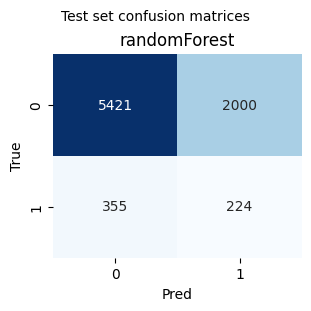

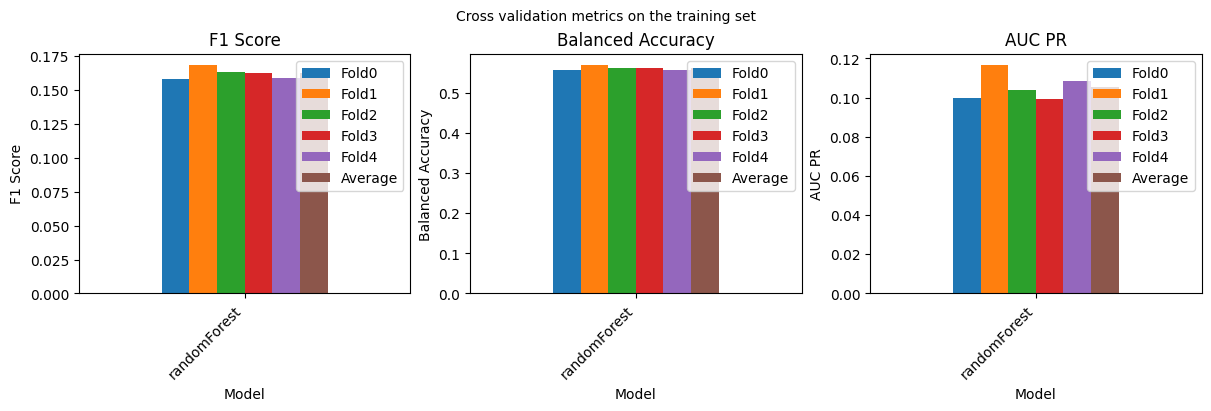

In [ ]:
## Best model so far
smote = SMOTE(random_state=seed, sampling_strategy=0.35)
resample = SMOTEENN(smote=smote, enn=EditedNearestNeighbours(sampling_strategy='majority', n_neighbors=5))
preprocessing = [('r', resample)]

model = RandomForestClassifier(random_state=seed)
classifiers = {'randomForest': model}

cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm = evaluate_models(
    classifiers, X_train, y_train, X_test, y_test, preprocessing=preprocessing, seed=seed)

plot_cross_val_metrics(classifiers, cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm)

In [ ]:
weights_list = [ 
    {0: 1, 1: 100},
    {0: 1, 1: 1},
    {0: 1, 1: 2},
    {0: 1, 1: 5},
    {0: 1, 1: 10},
    {0: 1, 1: 15},
    {0: 1, 1: 20},
    'balanced',        # Automatically balanced based on class frequencies
    'balanced_subsample'  # Balanced within each bootstrap sample
]


# Adjust display options
pd.set_option('display.width', 1000)  # Increase width
pd.set_option('display.max_columns', None)  # Show all columns

smote = SMOTE(random_state=seed, sampling_strategy=0.35)
resample = SMOTEENN(smote=smote, enn=EditedNearestNeighbours(sampling_strategy='majority', n_neighbors=5))
preprocessing = [('r', resample)]
    
print('Performance on the test: ')
for idx, weights in enumerate(weights_list): 
    model = RandomForestClassifier(class_weight=weights, random_state=seed)
    classifiers = {'randomForest': model}

    print("Weights: ", weights)
    cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm = evaluate_models(
        classifiers, X_train, y_train, X_test, y_test, preprocessing=preprocessing, seed=seed)

    print(metrics_df)
    
    


Performance on the test: 
Weights:  {0: 1, 1: 100}
          Model  Accuracy  Balanced Accuracy  Recall  Precision  F1 Score  AUC PR
0  randomForest      0.71               0.56    0.38       0.10      0.16    0.08
Weights:  {0: 1, 1: 1}
          Model  Accuracy  Balanced Accuracy  Recall  Precision  F1 Score  AUC PR
0  randomForest      0.71               0.56    0.39       0.10      0.16    0.08
Weights:  {0: 1, 1: 2}
          Model  Accuracy  Balanced Accuracy  Recall  Precision  F1 Score  AUC PR
0  randomForest      0.71               0.56    0.38       0.10      0.16    0.08
Weights:  {0: 1, 1: 5}
          Model  Accuracy  Balanced Accuracy  Recall  Precision  F1 Score  AUC PR
0  randomForest      0.71               0.56    0.38       0.10      0.16    0.08
Weights:  {0: 1, 1: 10}
          Model  Accuracy  Balanced Accuracy  Recall  Precision  F1 Score  AUC PR
0  randomForest      0.71               0.56    0.39       0.10      0.16    0.08
Weights:  {0: 1, 1: 15}
          Mo

In [ ]:
## Balanced weight values
smote = SMOTE(random_state=seed, sampling_strategy=0.35)
resample = SMOTEENN(smote=smote, enn=EditedNearestNeighbours(sampling_strategy='majority', n_neighbors=5))
X_train_Sam, y_train_Sam = resample.fit_resample(X_train, y_train)
counts = y_train_Sam.value_counts()
total_samples = len(y_train_Sam)
weights = {0: total_samples / (2 * counts[0]), 1: total_samples / (2 * counts[1])}
print(weights[0]/weights[0])
print(weights[1]/weights[0])

1.0
1.7001636346135336


Performance on the test: 
                Model  Accuracy  Balanced Accuracy  Recall  Precision  F1 Score  AUC PR
0        randomForest      0.71               0.56    0.39       0.10      0.16    0.08
1  randomForest_tuned      0.71               0.56    0.40       0.10      0.16    0.08


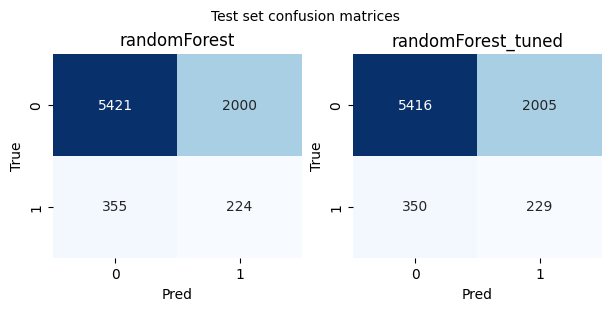

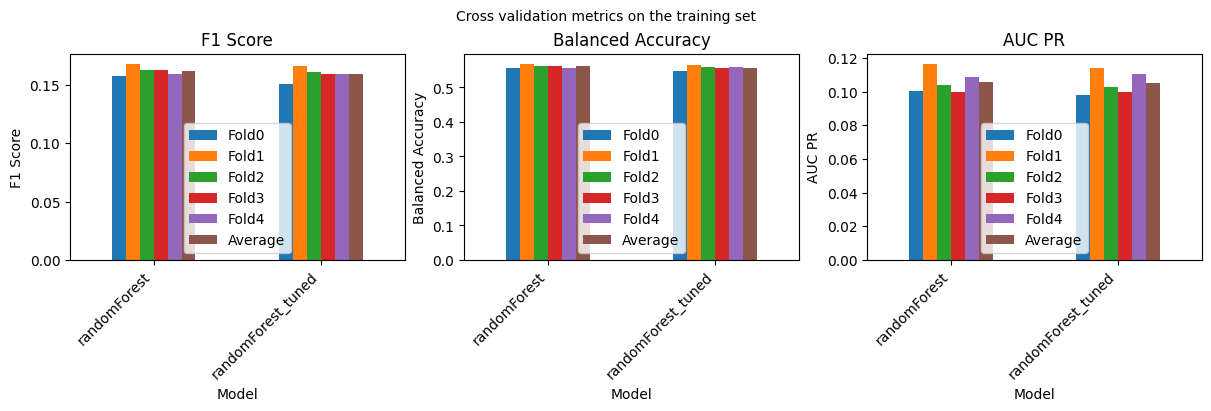

In [ ]:

smote = SMOTE(random_state=seed, sampling_strategy=0.35)
resample = SMOTEENN(smote=smote, enn=EditedNearestNeighbours(sampling_strategy='majority', n_neighbors=5))
preprocessing = [('r', resample)]

model_tuned= RandomForestClassifier(class_weight='balanced', random_state=seed)
model = RandomForestClassifier(random_state=seed)
classifiers = {'randomForest': model,
              'randomForest_tuned': model_tuned}

cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm = evaluate_models(
    classifiers, X_train, y_train, X_test, y_test, preprocessing=preprocessing, seed=seed)

plot_cross_val_metrics(classifiers, cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm)

In [ ]:
smote = SMOTE(random_state=seed, sampling_strategy=0.35)
resample = SMOTEENN(smote=smote, enn=EditedNearestNeighbours(sampling_strategy='majority', n_neighbors=5))
preprocessing = [('r', resample)]

def objective(trial):
    """ Objective function for tuning Forest Classifier """
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
    }

    model = RandomForestClassifier(**params, class_weight='balanced', random_state=seed, n_jobs=1)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

     # Applying resampling
    pipeline = Pipeline(steps=[('r', resample),('m', model)])
    
    scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='recall', n_jobs=1)

    return np.mean(scores)

# Run Optuna optimization
study_RF = optuna.create_study(direction='maximize', sampler=optuna.samplers.NSGAIISampler(seed=seed))
study_RF.optimize(objective, n_trials=100)

# Best hyperparameters
print("Best parameters:", study_RF.best_params)

[I 2025-04-06 17:02:44,955] A new study created in memory with name: no-name-5ce20916-2cb3-4b86-8a86-2003dabbbd91
[I 2025-04-06 17:04:08,974] Trial 0 finished with value: 0.47775284873761825 and parameters: {'n_estimators': 250, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 12, 'criterion': 'entropy', 'max_features': None}. Best is trial 0 with value: 0.47775284873761825.
[I 2025-04-06 17:04:59,858] Trial 1 finished with value: 0.5468049452595516 and parameters: {'n_estimators': 500, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 6, 'criterion': 'gini', 'max_features': None}. Best is trial 1 with value: 0.5468049452595516.
[I 2025-04-06 17:05:20,449] Trial 2 finished with value: 0.5377709093617339 and parameters: {'n_estimators': 300, 'max_depth': 7, 'min_samples_split': 18, 'min_samples_leaf': 6, 'criterion': 'gini', 'max_features': 'sqrt'}. Best is trial 1 with value: 0.5468049452595516.
[I 2025-04-06 17:06:59,654] Trial 3 finished with value: 0.4005185447

Best parameters: {'n_estimators': 300, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 20, 'criterion': 'entropy', 'max_features': 'log2'}


In [ ]:
study_RF.best_params 

{'n_estimators': 300,
 'max_depth': 3,
 'min_samples_split': 7,
 'min_samples_leaf': 20,
 'criterion': 'entropy',
 'max_features': 'log2'}

Performance on the test: 
                Model  Accuracy  Balanced Accuracy  Recall  Precision  F1 Score  AUC PR
0        randomForest      0.71               0.56    0.40       0.10      0.16    0.08
1  randomForest_tuned      0.58               0.58    0.59       0.10      0.17    0.09


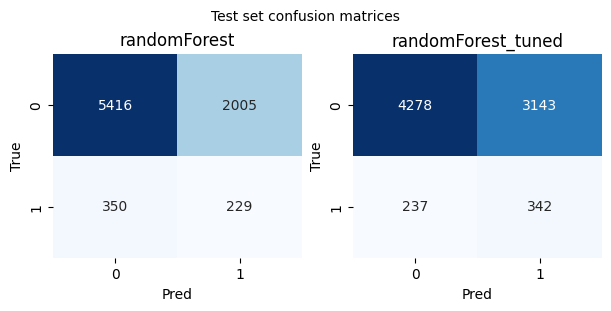

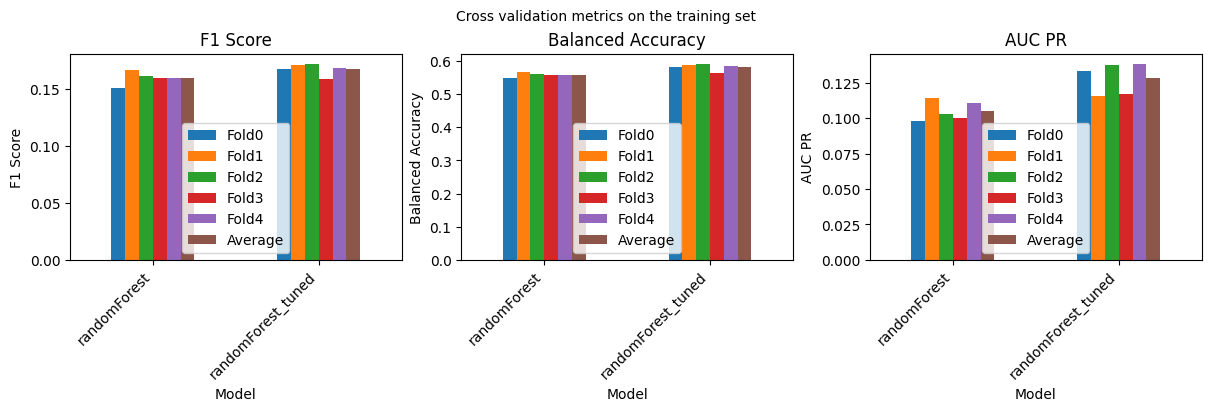

In [ ]:
best_params_RF = study_RF.best_params 

smote = SMOTE(random_state=seed, sampling_strategy=0.35)
resample = SMOTEENN(smote=smote, enn=EditedNearestNeighbours(sampling_strategy='majority', n_neighbors=5))
preprocessing = [('r', resample)]

model_tuned= RandomForestClassifier(**best_params_RF, class_weight='balanced', random_state=seed)
model = RandomForestClassifier(random_state=seed, class_weight='balanced')
classifiers = {'randomForest': model,
              'randomForest_tuned': model_tuned}

cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm = evaluate_models(
    classifiers, X_train, y_train, X_test, y_test, preprocessing=preprocessing, seed=seed)

plot_cross_val_metrics(classifiers, cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm)

In [ ]:
def objective(trial):
    """ Objective function for tuning Forest Classifier """
    params = {
    'n_estimators': trial.suggest_int('n_estimators', 50, 500, step=10),
    'max_depth': trial.suggest_int('max_depth', 3, 20),
    'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
    'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
    'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
    'min_impurity_decrease': trial.suggest_float('min_impurity_decrease', 0.0, 0.1), # Added min_impurity_decrease
    'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 10, 100), # Optional: Add max_leaf_nodes
    'min_weight_fraction_leaf': trial.suggest_float('min_weight_fraction_leaf', 0.0, 0.5), # Optional
}

    model = RandomForestClassifier(**params, class_weight='balanced', random_state=seed, n_jobs=1)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

     # Applying resampling
    pipeline = Pipeline(steps=[('r', resample),('m', model)])
    
    scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='recall', n_jobs=1)

    return np.mean(scores)

# Run Optuna optimization
study_RF = optuna.create_study(direction='maximize', sampler=optuna.samplers.NSGAIISampler(seed=seed))
study_RF.optimize(objective, n_trials=200)

# Best hyperparameters
print("Best parameters:", study_RF.best_params)

[I 2025-04-06 19:23:07,996] A new study created in memory with name: no-name-d61e6680-c108-41fc-bc21-d2b43baa3ab8
[I 2025-04-06 19:23:24,788] Trial 0 finished with value: 0.2 and parameters: {'n_estimators': 270, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 12, 'criterion': 'entropy', 'max_features': None, 'min_impurity_decrease': 0.09982149314812182, 'max_leaf_nodes': 13, 'min_weight_fraction_leaf': 0.207041909007959}. Best is trial 0 with value: 0.2.
[I 2025-04-06 19:23:39,127] Trial 1 finished with value: 0.8113847099128622 and parameters: {'n_estimators': 180, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 9, 'criterion': 'entropy', 'max_features': None, 'min_impurity_decrease': 0.027572682763323666, 'max_leaf_nodes': 73, 'min_weight_fraction_leaf': 0.06186505322810054}. Best is trial 1 with value: 0.8113847099128622.
[I 2025-04-06 19:23:51,997] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 440, 'max_depth': 9, 'min_samples_split': 

KeyboardInterrupt: 

Performance on the test: 
                Model  Accuracy  Balanced Accuracy  Recall  Precision  F1 Score  AUC PR
0        randomForest      0.71               0.56    0.40       0.10      0.16    0.08
1  randomForest_tuned      0.43               0.55    0.69       0.08      0.15    0.08


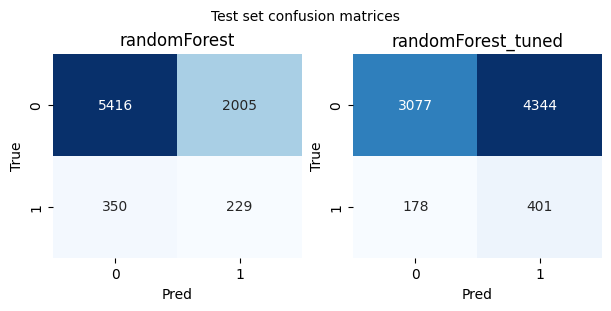

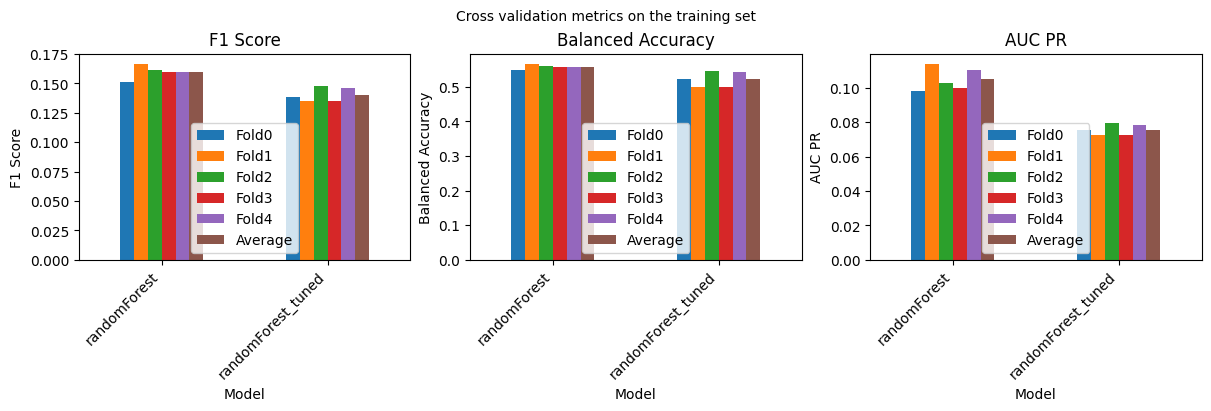

In [ ]:
best_params_RF =  {'n_estimators': 210, 'max_depth': 3, 'min_samples_split': 19, 'min_samples_leaf': 14, 'criterion': 'entropy', 'max_features': 'sqrt', 'min_impurity_decrease': 0.020320770001149225, 'max_leaf_nodes': 65, 'min_weight_fraction_leaf': 0.3586597876206249} 

smote = SMOTE(random_state=seed, sampling_strategy=0.35)
resample = SMOTEENN(smote=smote, enn=EditedNearestNeighbours(sampling_strategy='majority', n_neighbors=5))
preprocessing = [('r', resample)]

model_tuned= RandomForestClassifier(**best_params_RF, class_weight='balanced', random_state=seed)
model = RandomForestClassifier(random_state=seed, class_weight='balanced')
classifiers = {'randomForest': model,
              'randomForest_tuned': model_tuned}

cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm = evaluate_models(
    classifiers, X_train, y_train, X_test, y_test, preprocessing=preprocessing, seed=seed)

plot_cross_val_metrics(classifiers, cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm)

Performance on the test: 
                Model  Accuracy  Balanced Accuracy  Recall  Precision  F1 Score  AUC PR
0        randomForest      0.71               0.56    0.40       0.10      0.16    0.08
1  randomForest_tuned      0.58               0.57    0.54       0.09      0.16    0.08


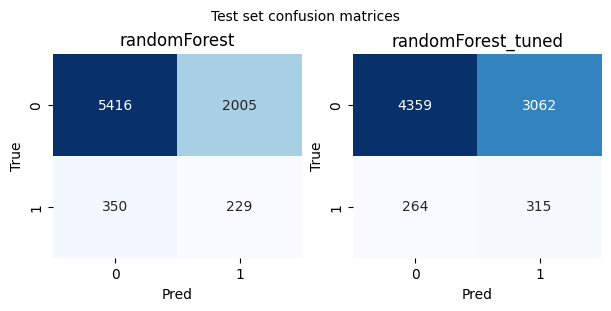

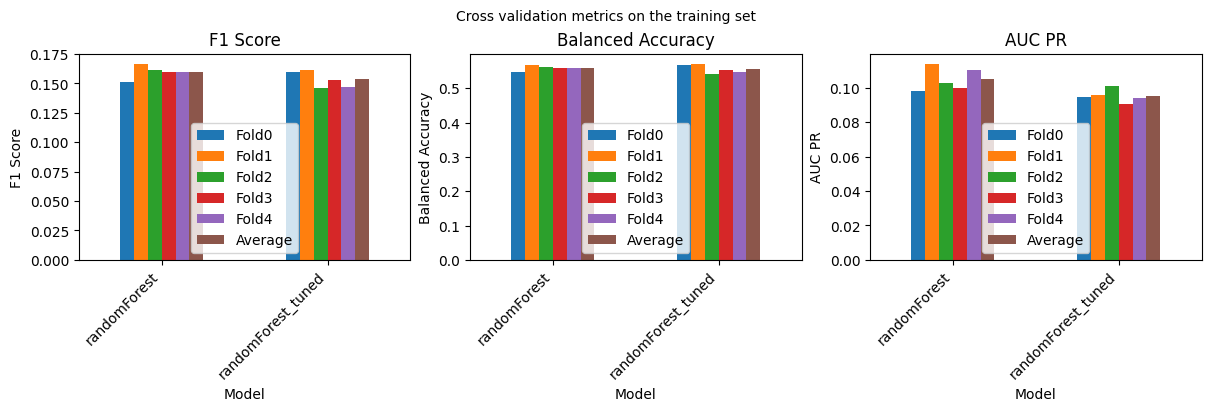

In [ ]:
best_params_RF =  {'n_estimators': 420, 'max_depth': 17, 'min_samples_split': 13, 'min_samples_leaf': 6, 'criterion': 'gini', 'max_features': 'log2', 'min_impurity_decrease': 0.01192010790498248, 'max_leaf_nodes': 52, 'min_weight_fraction_leaf': 0.14502180724492164}
smote = SMOTE(random_state=seed, sampling_strategy=0.35)
resample = SMOTEENN(smote=smote, enn=EditedNearestNeighbours(sampling_strategy='majority', n_neighbors=5))
preprocessing = [('r', resample)]

model_tuned= RandomForestClassifier(**best_params_RF, class_weight='balanced', random_state=seed)
model = RandomForestClassifier(random_state=seed, class_weight='balanced')
classifiers = {'randomForest': model,
              'randomForest_tuned': model_tuned}

cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm = evaluate_models(
    classifiers, X_train, y_train, X_test, y_test, preprocessing=preprocessing, seed=seed)

plot_cross_val_metrics(classifiers, cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm)

Performance on the test: 
                Model  Accuracy  Balanced Accuracy  Recall  Precision  F1 Score  AUC PR
0        randomForest      0.71               0.56    0.40       0.10      0.16    0.08
1  randomForest_tuned      0.34               0.54    0.79       0.08      0.15    0.08


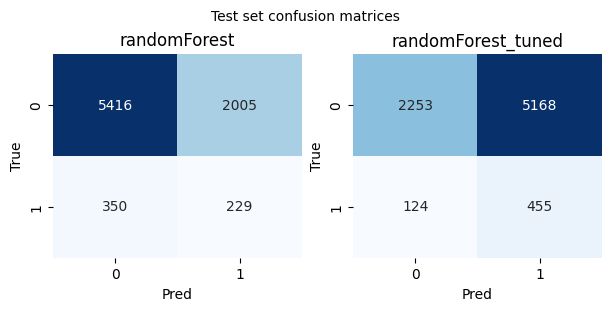

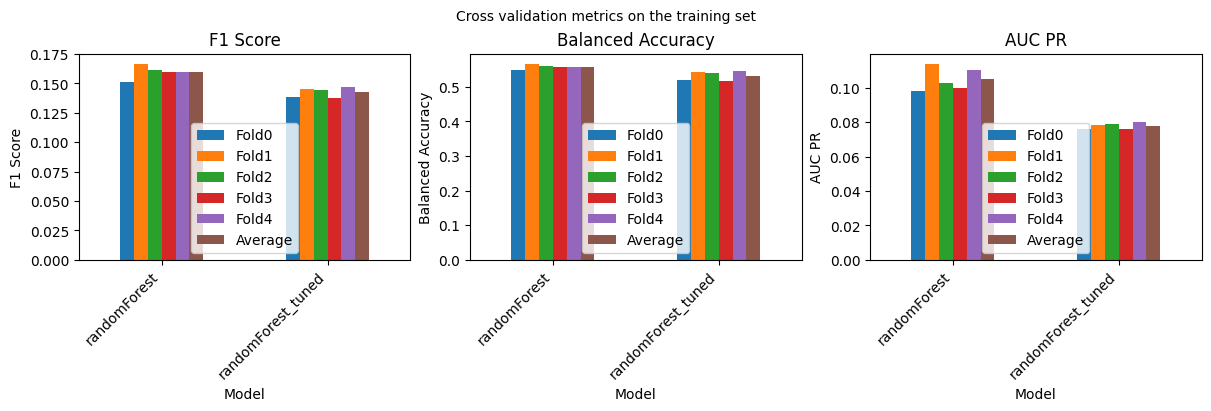

In [16]:
best_params_RF = {'n_estimators': 180, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 9, 'criterion': 'entropy', 'max_features': None, 'min_impurity_decrease': 0.027572682763323666, 'max_leaf_nodes': 73, 'min_weight_fraction_leaf': 0.06186505322810054}
smote = SMOTE(random_state=seed, sampling_strategy=0.35)
resample = SMOTEENN(smote=smote, enn=EditedNearestNeighbours(sampling_strategy='majority', n_neighbors=5))
preprocessing = [('r', resample)]

model_tuned= RandomForestClassifier(**best_params_RF, class_weight='balanced', random_state=seed)
model = RandomForestClassifier(random_state=seed, class_weight='balanced')
classifiers = {'randomForest': model,
              'randomForest_tuned': model_tuned}

cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm = evaluate_models(
    classifiers, X_train, y_train, X_test, y_test, preprocessing=preprocessing, seed=seed)

plot_cross_val_metrics(classifiers, cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm)

### Model 2

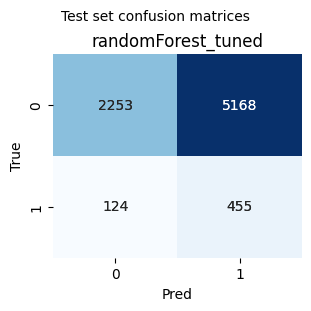

In [19]:
# Initialize StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
model_level1 = RandomForestClassifier(**best_params_RF, class_weight='balanced', random_state=seed)
smote = SMOTE(random_state=seed, sampling_strategy=0.35)
resample_level1 = SMOTEENN(smote=smote, enn=EditedNearestNeighbours(sampling_strategy='majority', n_neighbors=5))

steps = [('r', resample_level1),('m', model_level1)]

pipeline = Pipeline(steps=steps)

pipeline.fit(X_train, y_train)

# Make predictions
y_pred_level1 = pipeline.predict(X_test)


cm = confusion_matrix(y_test, y_pred_level1)
fig, ax = plt.subplots(1, 1, figsize=(3* 1, 3), constrained_layout=True)

for idx, (clf_name, clf) in enumerate(classifiers.items()):
    s = sns.heatmap(cm, ax=ax, cbar=False, annot=True, fmt='g', cmap='Blues')
    s.set_xlabel('Pred')
    s.set_ylabel('True')
    s.set_title(clf_name)
fig.suptitle('Test set confusion matrices', fontsize=10)
plt.show()

# Filter the DataFrame based on the positive class label in the predictions


In [ ]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


x_train shape:  (32000, 36)
y_train shape:  (32000,)
x_test shape:  (8000, 36)
y_test shape:  (8000,)


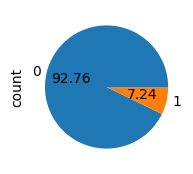

In [19]:
# Select demographic and financial fields
df_model2 = df.copy()

# Apply Label Encoding to binary categorical features
binary_features = ["default", "housing", "loan", "y"]
label_encoders = {}
for col in binary_features:
    label_encoders[col] = LabelEncoder()
    df_model2[col] = label_encoders[col].fit_transform(df_model2[col])

# Apply One-Hot Encoding to multi-class categorical features
multi_class_features = ["job", "marital", "education", "contact", "month"]
df_model2 = pd.get_dummies(df_model2, columns=multi_class_features, drop_first=True)

# Separate features and target variable
X2 = df_model2.drop(columns=["y"])
y2 = df_model2["y"]

# Split into training and testing sets (80% train, 20% test)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=seed, stratify=y2)

# Numerical features for scaling
numerical_features = ["age", "balance", "day", "duration", "campaign"]

# Apply Standard Scaling to numerical features
scaler = StandardScaler()
X_train2[numerical_features] = scaler.fit_transform(X_train2[numerical_features])
X_test2[numerical_features] = scaler.transform(X_test2[numerical_features])

# Display the prepared training set
#X_train.head(3), y_train.head(3)

print('x_train shape: ', X_train2.shape)
print('y_train shape: ', y_train2.shape)
print('x_test shape: ', X_test2.shape)
print('y_test shape: ', y_test2.shape)

plt.figure(figsize=(2, 2))
y_train2.value_counts().plot.pie(autopct='%.2f')
plt.show()

In [21]:
df_model2.columns

Index(['age', 'default', 'balance', 'housing', 'loan', 'day', 'duration', 'campaign', 'y', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_married', 'marital_single', 'education_secondary', 'education_tertiary', 'education_unknown', 'contact_telephone', 'contact_unknown', 'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct'], dtype='object')

In [ ]:
from math import ceil
def custom_recall_precision(y_true, y_pred):
    recall = recall_score(y_true, y_pred) #, average='weighted') # Or appropriate averaging
    precision = precision_score(y_true, y_pred) #, average='weighted', zero_division=0) # Or appropriate averaging
    return (ceil(recall * 100) / 100, ceil(precision * 100) / 100) # Or {'recall': recall, 'precision': precision}

clf = LazyClassifier(verbose=-1,ignore_warnings=True, predictions=True, random_state=seed, custom_metric=custom_recall_precision)
models,predictions = clf.fit(X_train2, X_test2, y_train2, y_test2)

models

[('AdaBoostClassifier', <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>), ('BaggingClassifier', <class 'sklearn.ensemble._bagging.BaggingClassifier'>), ('BernoulliNB', <class 'sklearn.naive_bayes.BernoulliNB'>), ('CalibratedClassifierCV', <class 'sklearn.calibration.CalibratedClassifierCV'>), ('CategoricalNB', <class 'sklearn.naive_bayes.CategoricalNB'>), ('DecisionTreeClassifier', <class 'sklearn.tree._classes.DecisionTreeClassifier'>), ('DummyClassifier', <class 'sklearn.dummy.DummyClassifier'>), ('ExtraTreeClassifier', <class 'sklearn.tree._classes.ExtraTreeClassifier'>), ('ExtraTreesClassifier', <class 'sklearn.ensemble._forest.ExtraTreesClassifier'>), ('GaussianNB', <class 'sklearn.naive_bayes.GaussianNB'>), ('KNeighborsClassifier', <class 'sklearn.neighbors._classification.KNeighborsClassifier'>), ('LabelPropagation', <class 'sklearn.semi_supervised._label_propagation.LabelPropagation'>), ('LabelSpreading', <class 'sklearn.semi_supervised._label_propagation.LabelSp

 97%|█████████▋| 28/29 [06:23<00:03,  3.93s/it]

[LightGBM] [Info] Number of positive: 2317, number of negative: 29683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 659
[LightGBM] [Info] Number of data points in the train set: 32000, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.072406 -> initscore=-2.550301
[LightGBM] [Info] Start training from score -2.550301


100%|██████████| 29/29 [06:23<00:00, 13.23s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,custom_recall_precision,Time Taken
Model,,,,,,
NearestCentroid,0.89,0.80,0.80,0.90,"(0.7, 0.36)",0.10
GaussianNB,0.93,0.69,0.69,0.93,"(0.42, 0.55)",0.09
QuadraticDiscriminantAnalysis,0.93,0.69,0.69,0.93,"(0.42, 0.54)",0.11
LinearDiscriminantAnalysis,0.93,0.69,0.69,0.93,"(0.41, 0.55)",0.38
LGBMClassifier,0.93,0.65,0.65,0.93,"(0.33, 0.59)",0.35
DecisionTreeClassifier,0.90,0.65,0.65,0.90,"(0.35, 0.33)",0.25
PassiveAggressiveClassifier,0.84,0.64,0.64,0.87,"(0.41, 0.21)",0.11
XGBClassifier,0.93,0.64,0.64,0.92,"(0.31, 0.55)",0.57
ExtraTreeClassifier,0.91,0.64,0.64,0.90,"(0.34, 0.35)",0.09


[LightGBM] [Info] Number of positive: 1854, number of negative: 23746
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000977 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 705
[LightGBM] [Info] Number of data points in the train set: 25600, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.072422 -> initscore=-2.550069
[LightGBM] [Info] Start training from score -2.550069
[LightGBM] [Info] Number of positive: 1854, number of negative: 23746
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000838 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 707
[LightGBM] [Info] Number of data points in the train set: 25600, number of used features: 35
[LightGBM] [Info] [bin

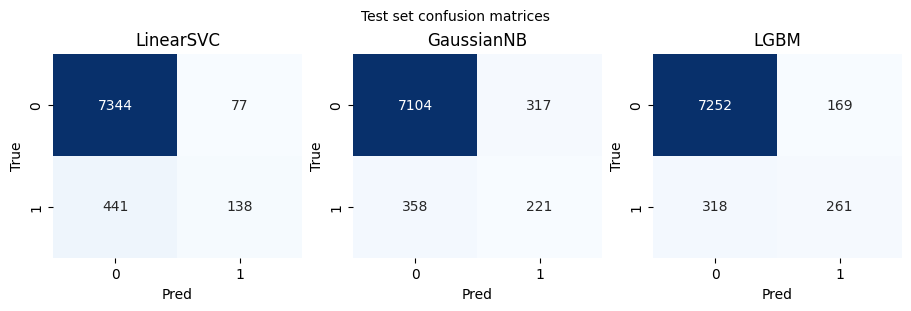

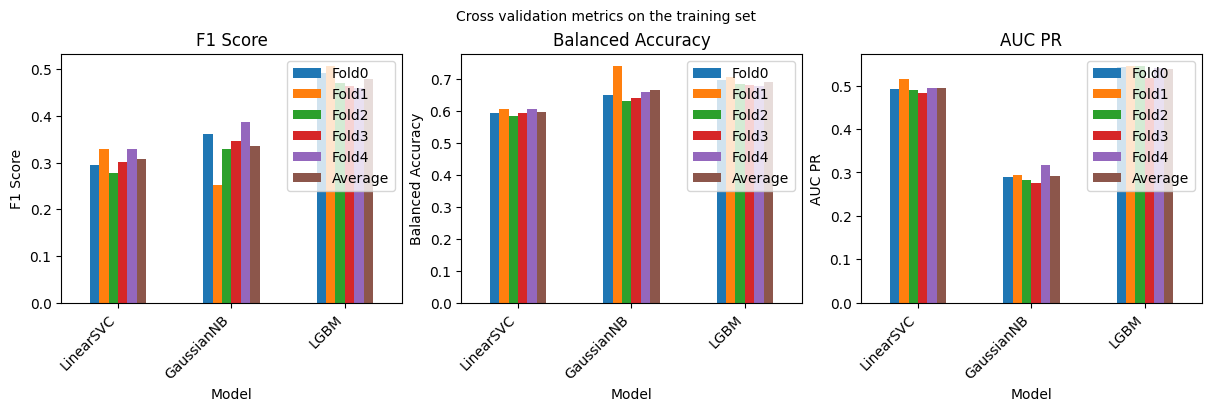

In [ ]:
# Re-training the selected models to evaluate consistency with LazyPredict results

classifiers = {
    'LinearSVC': LinearSVC(random_state=seed),
    'GaussianNB': GaussianNB(),
    'LGBM': LGBMClassifier(random_state=seed),
}

cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm = evaluate_models(
    classifiers, X_train2, y_train2, X_test2, y_test2, seed=seed)

plot_cross_val_metrics(classifiers, cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm)

GaussianNB does not have the option to tune class weights. Class weights allow you to assign different penalties to misclassifying different classes during optimization. GaussianNB does not have an optimization process. 

We, it will be difficult to tune this model further. I will be choosing a model out of LinearSVC and LGBM.

In [ ]:
#fig, axes = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)

smote = SMOTE(random_state=seed, sampling_strategy=0.25) #sampling_strategy = #minority_samples_after_resampling/#majority_samples
X_train_overSam, y_train_overSam = smote.fit_resample(X_train2, y_train2)
print("Class distribution after over sampling:", pd.Series(y_train_overSam).value_counts())
# plt.figure(figsize=(2, 2))
# y_train_overSam.value_counts().plot.pie(autopct='%.2f')
# plt.show()

# 1. RandomUnderSampler
rus = RandomUnderSampler(random_state=seed, sampling_strategy=0.25)
X_train_rus, y_train_rus = rus.fit_resample(X_train2, y_train2)
print("Class distribution after RandomUnderSampler:", pd.Series(y_train_rus).value_counts())

smote = SMOTE(random_state=seed, sampling_strategy=0.25)
resample = SMOTEENN(smote=smote, enn=EditedNearestNeighbours(sampling_strategy='majority')) #, n_neighbors=5
X_train_smoteenn, y_train_smoteenn = resample.fit_resample(X_train2, y_train2)
print("Class distribution after Over and under sampling:", pd.Series(y_train_smoteenn).value_counts())

Class distribution after over sampling: y
0    29683
1     7420
Name: count, dtype: int64
Class distribution after RandomUnderSampler: y
0    9268
1    2317
Name: count, dtype: int64
Class distribution after Over and under sampling: y
0    26586
1     7420
Name: count, dtype: int64


[LightGBM] [Info] Number of positive: 5936, number of negative: 23746
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002714 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1329
[LightGBM] [Info] Number of data points in the train set: 29682, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199987 -> initscore=-1.386379
[LightGBM] [Info] Start training from score -1.386379
[LightGBM] [Info] Number of positive: 5936, number of negative: 23746
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1328
[LightGBM] [Info] Number of data points in the train set: 29682, number of used features: 35
[LightGBM] [Info] [b

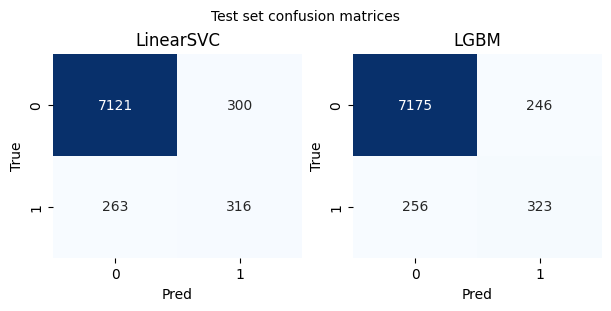

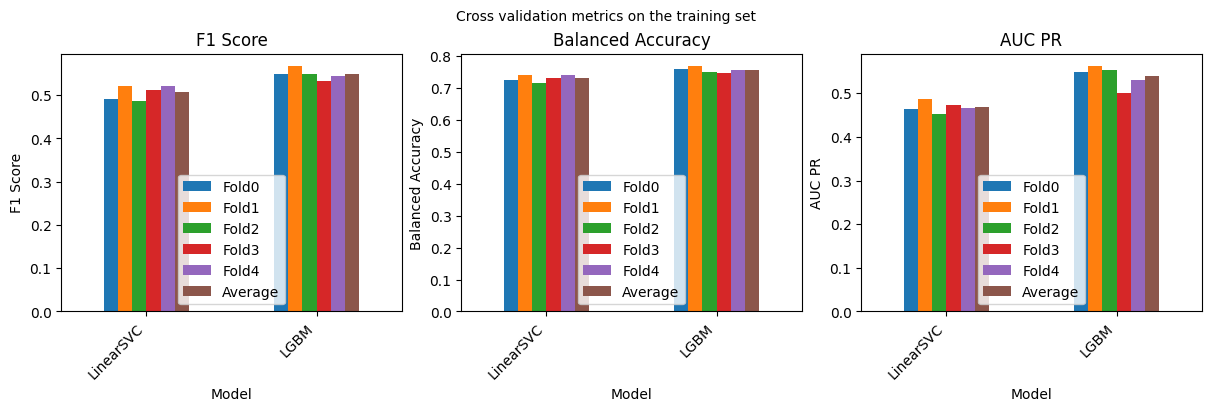

In [ ]:
smoteOs = SMOTE(random_state=seed, sampling_strategy=0.25)

preprocessing = [('r', smoteOs)]

#model = LinearSVC(random_state=seed, class_weight='balanced')
classifiers = {'LinearSVC':  LinearSVC(random_state=seed),  
            'LGBM': LGBMClassifier(random_state=seed)}

cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm = evaluate_models(
    classifiers, X_train2, y_train2, X_test2, y_test2, preprocessing=preprocessing, seed=seed)

plot_cross_val_metrics(classifiers, cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm)

[LightGBM] [Info] Number of positive: 1854, number of negative: 7416
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 9270, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Number of positive: 1854, number of negative: 7416
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 698
[LightGBM] [Info] Number of data points in the train set: 9270, number of used features: 35
[LightGBM] [Info] [binary:

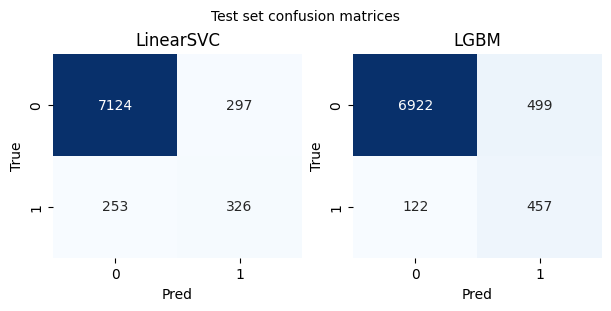

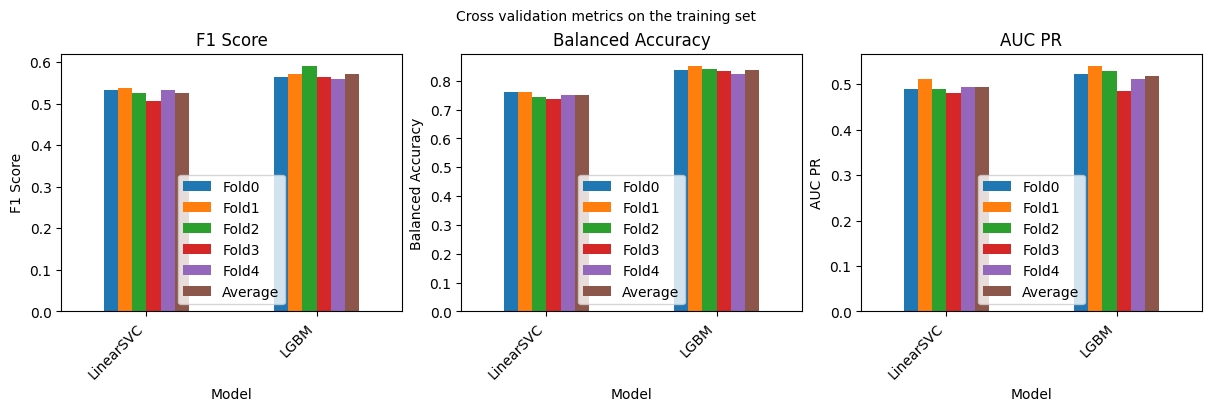

In [ ]:
rus = RandomUnderSampler(random_state=seed, sampling_strategy=0.25)

preprocessing = [('r', rus)]

#model = LinearSVC(random_state=seed, class_weight='balanced')
classifiers = {'LinearSVC':  LinearSVC(random_state=seed),  
            'LGBM': LGBMClassifier(random_state=seed)}

cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm = evaluate_models(
    classifiers, X_train2, y_train2, X_test2, y_test2, preprocessing=preprocessing, seed=seed)

plot_cross_val_metrics(classifiers, cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm)

[LightGBM] [Info] Number of positive: 5936, number of negative: 21151
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1329
[LightGBM] [Info] Number of data points in the train set: 27087, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219146 -> initscore=-1.270652
[LightGBM] [Info] Start training from score -1.270652
[LightGBM] [Info] Number of positive: 5936, number of negative: 21213
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1327
[LightGBM] [Info] Number of data points in the train set: 27149, number of used features: 35
[LightGBM] [Info] [b

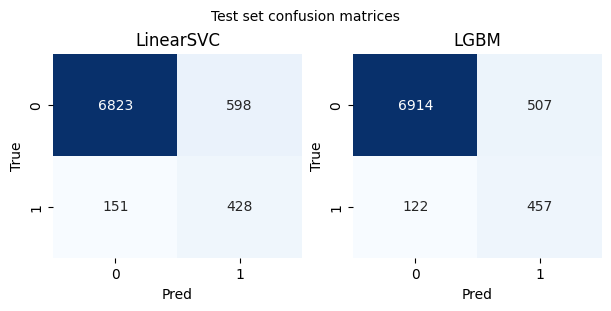

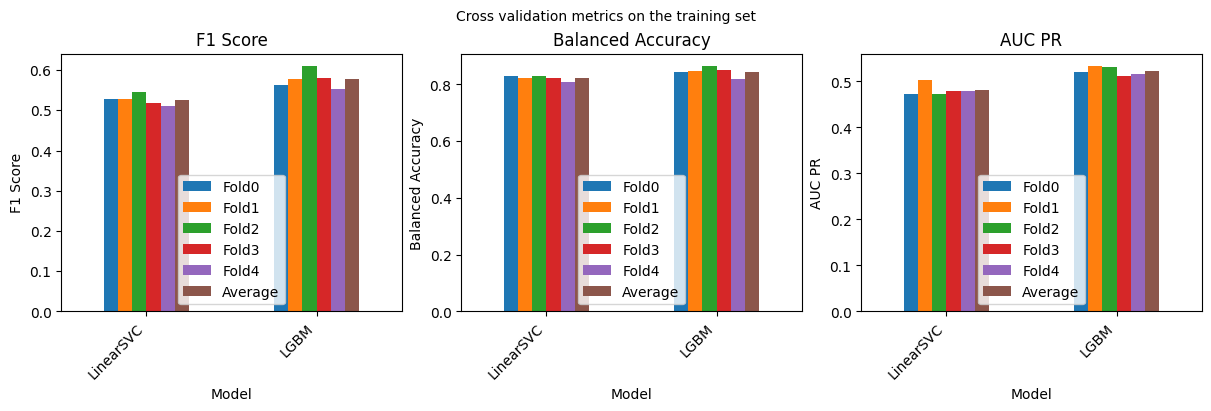

In [ ]:
smote = SMOTE(random_state=seed, sampling_strategy=0.25)
resample = SMOTEENN(smote=smote, enn=EditedNearestNeighbours(sampling_strategy='majority')) #, n_neighbors=5

preprocessing = [('r', resample)]

#model = LinearSVC(random_state=seed, class_weight='balanced')
classifiers = {'LinearSVC':  LinearSVC(random_state=seed),  
            'LGBM': LGBMClassifier(random_state=seed)}

cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm = evaluate_models(
    classifiers, X_train2, y_train2, X_test2, y_test2, preprocessing=preprocessing, seed=seed)

plot_cross_val_metrics(classifiers, cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm)

Undersampling leads to a very small number of negative samples. May not be helpful when learning the negative class and when trying to eliminate false positives.
With SMOTEENN, we can strike a balance.

Performance on the test: 
       Model  Accuracy  Balanced Accuracy  Recall  Precision  F1 Score  AUC PR
0  LinearSVC      0.85               0.87    0.89       0.31      0.46    0.29
1       LGBM      0.90               0.89    0.88       0.40      0.55    0.36


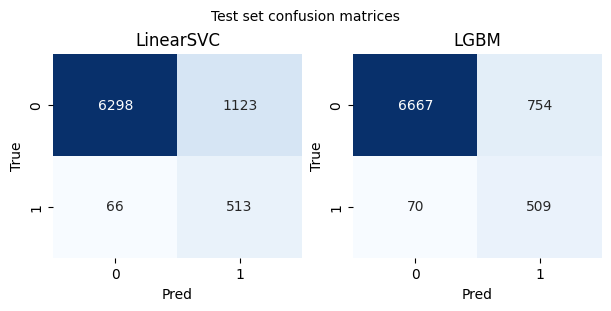

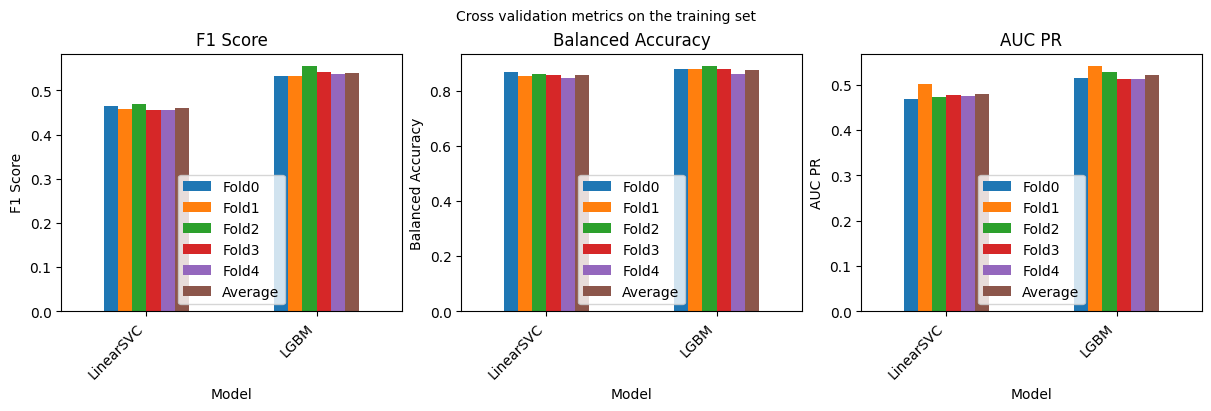

In [ ]:
smote = SMOTE(random_state=seed, sampling_strategy=0.25)
resample = SMOTEENN(smote=smote, enn=EditedNearestNeighbours(sampling_strategy='majority')) #, n_neighbors=5

preprocessing = [('r', resample)]

#model = LinearSVC(random_state=seed, class_weight='balanced')
classifiers = {'LinearSVC':  LinearSVC(random_state=seed, class_weight='balanced'),  
            'LGBM': LGBMClassifier(random_state=seed, class_weight='balanced', verbose=-1)}

cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm = evaluate_models(
    classifiers, X_train2, y_train2, X_test2, y_test2, preprocessing=preprocessing, seed=seed)

plot_cross_val_metrics(classifiers, cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm)

LGBM responds to class weights better than LinearSVC.
Let's try to tune class weights for LGBM.

In [ ]:
## Tuning positive class weight for LGBM

smote = SMOTE(random_state=seed, sampling_strategy=0.25)
resample = SMOTEENN(smote=smote, enn=EditedNearestNeighbours(sampling_strategy='majority')) #, n_neighbors=5
preprocessing = [('r', resample)]

neg_count = np.sum(y_train2 == 0)
pos_count = np.sum(y_train2 == 1)
initial_weight = neg_count / pos_count
weights = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, initial_weight * 0.5, initial_weight * 0.8, initial_weight, initial_weight * 1.2, initial_weight * 1.5, initial_weight * 2.0]

print('Performance on the test set: ')
for idx, weight in enumerate(weights): 
    model = LGBMClassifier(random_state=seed, scale_pos_weight=weight, verbose=-1) #scaler_pos_weight=weight,
    classifiers = {'LGBM': model}

    print("Weight: ", weight)
    cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm = evaluate_models(
        classifiers, X_train2, y_train2, X_test2, y_test2, preprocessing=preprocessing, seed=seed)

    print(metrics_df)
    


Performance on the test set: 
Weight:  1.0
  Model  Accuracy  Balanced Accuracy  Recall  Precision  F1 Score  AUC PR
0  LGBM      0.92               0.86    0.79       0.47      0.59    0.39
Weight:  2.0
  Model  Accuracy  Balanced Accuracy  Recall  Precision  F1 Score  AUC PR
0  LGBM      0.91               0.88    0.85       0.43      0.57    0.38
Weight:  3.0
  Model  Accuracy  Balanced Accuracy  Recall  Precision  F1 Score  AUC PR
0  LGBM      0.90               0.89    0.88       0.41      0.56    0.37
Weight:  4.0
  Model  Accuracy  Balanced Accuracy  Recall  Precision  F1 Score  AUC PR
0  LGBM      0.89               0.89    0.89       0.39      0.54    0.36
Weight:  5.0
  Model  Accuracy  Balanced Accuracy  Recall  Precision  F1 Score  AUC PR
0  LGBM      0.89               0.90    0.91       0.38      0.54    0.36
Weight:  6.0
  Model  Accuracy  Balanced Accuracy  Recall  Precision  F1 Score  AUC PR
0  LGBM      0.88               0.90    0.92       0.38      0.53    0.35
Weig

Performance on the test: 
           Model  Accuracy  Balanced Accuracy  Recall  Precision  F1 Score  AUC PR
0           LGBM      0.92               0.86    0.79       0.47      0.59    0.39
1  LGBM_weighted      0.88               0.90    0.92       0.38      0.53    0.35


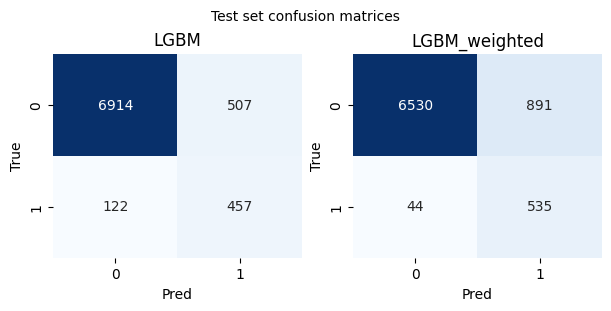

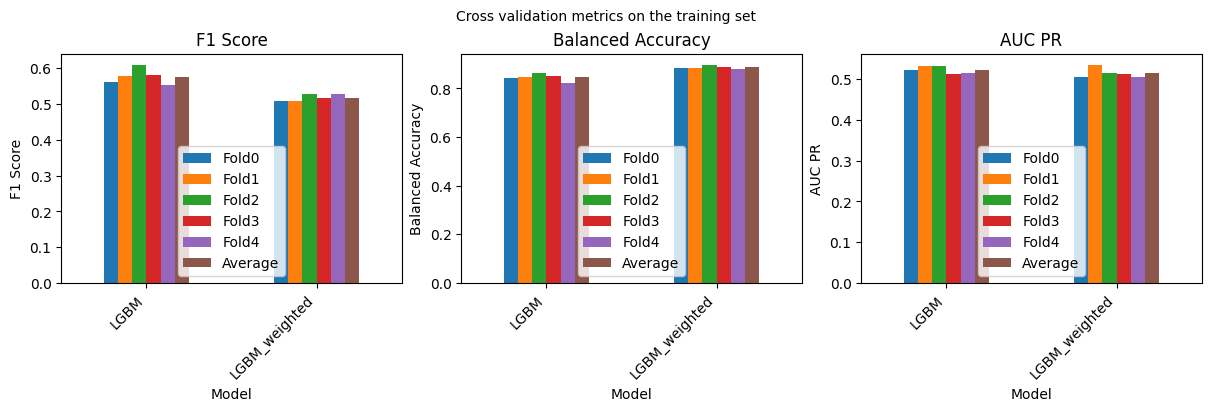

In [ ]:
smote = SMOTE(random_state=seed, sampling_strategy=0.25)
resample = SMOTEENN(smote=smote, enn=EditedNearestNeighbours(sampling_strategy='majority')) #, n_neighbors=5

preprocessing = [('r', resample)]

#model = LinearSVC(random_state=seed, class_weight='balanced')
classifiers = {'LGBM':  LGBMClassifier(random_state=seed, verbose=-1),  
            'LGBM_weighted': LGBMClassifier(random_state=seed, scale_pos_weight=initial_weight * 0.5, verbose=-1)}

cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm = evaluate_models(
    classifiers, X_train2, y_train2, X_test2, y_test2, preprocessing=preprocessing, seed=seed)

plot_cross_val_metrics(classifiers, cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm)

In [ ]:
def objective(trial):
    """ Objective function for tuning LGBM """
    lgb_params = {
        'objective': 'binary',
        'metric': 'binary_logloss', # Optuna needs a metric to optimize, but your evaluation will use f1_score
        'random_state': seed,
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 31, 150),
        'max_depth': trial.suggest_int('max_depth', -1, 15), # -1 means no limit
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 10.0, log=True),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 25),#initial_weight * 0.5, # Assuming this is already set
        'n_jobs': -1,
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'rf']), # You can restrict this if needed
    }

    if lgb_params['boosting_type'] == 'dart':
        lgb_params['dropout_rate'] = trial.suggest_float('dropout_rate', 0.0, 1.0)
    elif lgb_params['boosting_type'] == 'rf':
        lgb_params['bagging_fraction'] = trial.suggest_float('bagging_fraction', 0.6, 1.0)
        lgb_params['bagging_freq'] = trial.suggest_int('bagging_freq', 1, 10)

    model = LGBMClassifier(**lgb_params, verbose=-1)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

     # Applying resampling
    pipeline = Pipeline(steps=[('r', resample),('m', model)])
    
    scores = cross_val_score(pipeline, X_train2, y_train2, cv=skf, scoring='precision', n_jobs=1)

    return np.mean(scores)

# Run Optuna optimization
study_lgbm = optuna.create_study(direction='maximize', sampler=optuna.samplers.NSGAIISampler(seed=seed))
study_lgbm.optimize(objective, n_trials=200)

# Best hyperparameters
print("Best parameters:", study_lgbm.best_params)

[I 2025-04-13 23:04:29,459] A new study created in memory with name: no-name-7f5a559f-3343-401a-ae2c-2c922b720291


[I 2025-04-13 23:05:10,473] Trial 0 finished with value: 0.24202146740176214 and parameters: {'n_estimators': 531, 'learning_rate': 0.02047721682479363, 'num_leaves': 64, 'max_depth': 8, 'min_child_samples': 42, 'subsample': 0.8053052284413861, 'colsample_bytree': 0.8027291355203994, 'reg_alpha': 0.10933446970701463, 'reg_lambda': 0.13149158032925407, 'scale_pos_weight': 24.957158355549232, 'boosting_type': 'dart', 'dropout_rate': 0.6843933165161048}. Best is trial 0 with value: 0.24202146740176214.
[I 2025-04-13 23:05:19,059] Trial 1 finished with value: 0.3661854893522666 and parameters: {'n_estimators': 108, 'learning_rate': 0.01895013921371688, 'num_leaves': 114, 'max_depth': 15, 'min_child_samples': 66, 'subsample': 0.7685067424350684, 'colsample_bytree': 0.9375361177573227, 'reg_alpha': 0.012673813456391516, 'reg_lambda': 0.6221170278217757, 'scale_pos_weight': 3.969522554948826, 'boosting_type': 'gbdt'}. Best is trial 1 with value: 0.3661854893522666.
[I 2025-04-13 23:05:37,299]

Best parameters: {'n_estimators': 577, 'learning_rate': 0.07743253709006985, 'num_leaves': 83, 'max_depth': 14, 'min_child_samples': 40, 'subsample': 0.7838455571023754, 'colsample_bytree': 0.6618598795665314, 'reg_alpha': 0.46371640709358614, 'reg_lambda': 0.212914335576598, 'scale_pos_weight': 3.571864103196954, 'boosting_type': 'gbdt'}


Performance on the test: 
        Model  Accuracy  Balanced Accuracy  Recall  Precision  F1 Score  AUC PR
0        LGBM      0.92               0.86    0.79       0.47      0.59    0.39
1  LGBM_tuned      0.92               0.87    0.80       0.47      0.59    0.39


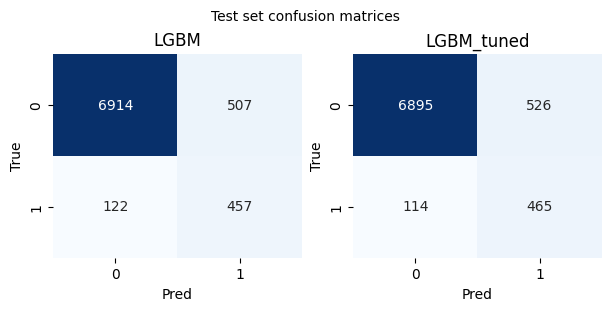

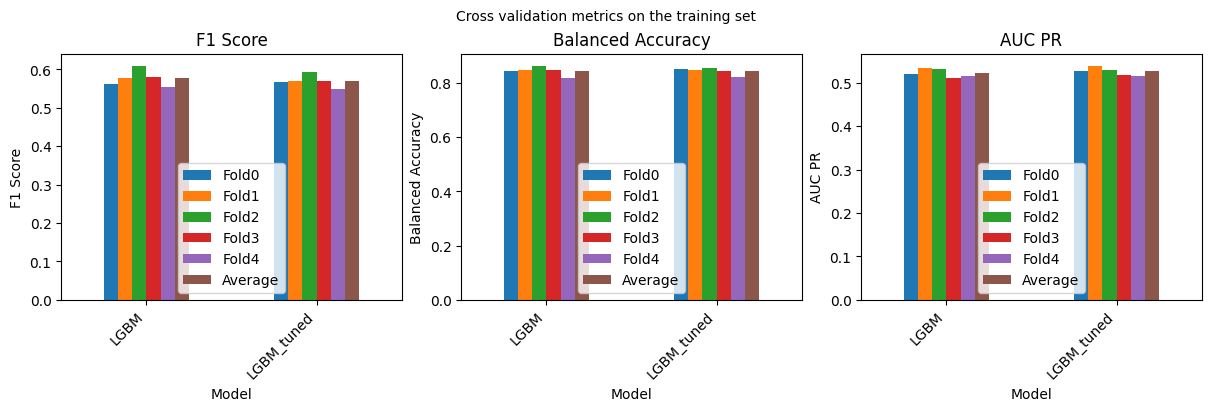

In [ ]:
smote = SMOTE(random_state=seed, sampling_strategy=0.25)
resample = SMOTEENN(smote=smote, enn=EditedNearestNeighbours(sampling_strategy='majority')) #, n_neighbors=5

preprocessing = [('r', resample)]
params = study_lgbm.best_params
#model = LinearSVC(random_state=seed, class_weight='balanced')
classifiers = {'LGBM':  LGBMClassifier(random_state=seed, verbose=-1),  
            'LGBM_tuned': LGBMClassifier(**params, verbose=-1)}

cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm = evaluate_models(
    classifiers, X_train2, y_train2, X_test2, y_test2, preprocessing=preprocessing, seed=seed)

plot_cross_val_metrics(classifiers, cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm)

Tuning without resampling

In [36]:
def objective(trial):
    """ Objective function for tuning LGBM """
    lgb_params = {
        'objective': 'binary',
        'metric': 'binary_logloss', # Optuna needs a metric to optimize, but your evaluation will use f1_score
        'random_state': seed,
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 31, 150),
        'max_depth': trial.suggest_int('max_depth', -1, 15), # -1 means no limit
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 10.0, log=True),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 25),#initial_weight * 0.5, # Assuming this is already set
        'n_jobs': -1,
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'rf']), # You can restrict this if needed
    }

    if lgb_params['boosting_type'] == 'dart':
        lgb_params['dropout_rate'] = trial.suggest_float('dropout_rate', 0.0, 1.0)
    elif lgb_params['boosting_type'] == 'rf':
        lgb_params['bagging_fraction'] = trial.suggest_float('bagging_fraction', 0.6, 1.0)
        lgb_params['bagging_freq'] = trial.suggest_int('bagging_freq', 1, 10)

    model = LGBMClassifier(**lgb_params, verbose=-1)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

     # Applying resampling
    pipeline = Pipeline(steps=[('m', model)])
    
    scores = cross_val_score(pipeline, X_train2, y_train2, cv=skf, scoring='precision', n_jobs=1)

    return np.mean(scores)

# Run Optuna optimization
study_lgbm = optuna.create_study(direction='maximize', sampler=optuna.samplers.NSGAIISampler(seed=seed))
study_lgbm.optimize(objective, n_trials=200)

# Best hyperparameters
print("Best parameters:", study_lgbm.best_params)

[I 2025-05-03 18:36:50,193] A new study created in memory with name: no-name-98d6ee0c-9147-42bf-92fc-79159660b3e1
[I 2025-05-03 18:37:21,980] Trial 0 finished with value: 0.2998646689204459 and parameters: {'n_estimators': 531, 'learning_rate': 0.02047721682479363, 'num_leaves': 64, 'max_depth': 8, 'min_child_samples': 42, 'subsample': 0.8053052284413861, 'colsample_bytree': 0.8027291355203994, 'reg_alpha': 0.10933446970701463, 'reg_lambda': 0.13149158032925407, 'scale_pos_weight': 24.957158355549232, 'boosting_type': 'dart', 'dropout_rate': 0.6843933165161048}. Best is trial 0 with value: 0.2998646689204459.
[I 2025-05-03 18:37:24,844] Trial 1 finished with value: 0.4835542443359464 and parameters: {'n_estimators': 108, 'learning_rate': 0.01895013921371688, 'num_leaves': 114, 'max_depth': 15, 'min_child_samples': 66, 'subsample': 0.7685067424350684, 'colsample_bytree': 0.9375361177573227, 'reg_alpha': 0.012673813456391516, 'reg_lambda': 0.6221170278217757, 'scale_pos_weight': 3.969522

Best parameters: {'n_estimators': 685, 'learning_rate': 0.010298163782403846, 'num_leaves': 94, 'max_depth': 1, 'min_child_samples': 48, 'subsample': 0.8986383555296303, 'colsample_bytree': 0.767803513070455, 'reg_alpha': 0.23848993068551644, 'reg_lambda': 0.12286776193294961, 'scale_pos_weight': 1.4297885198668192, 'boosting_type': 'dart', 'dropout_rate': 0.29600382185145535}


Tuning the model to optmize F1 score because it strikes a balance between recall and precision. 

In [48]:
smote = SMOTE(random_state=seed, sampling_strategy=0.25)
resample_level2 = SMOTEENN(smote=smote, enn=EditedNearestNeighbours(sampling_strategy='majority')) 

def objective(trial):
    """ Objective function for tuning LGBM """
    lgb_params = {
        'objective': 'binary',
        'metric': 'binary_logloss', # Optuna needs a metric to optimize, but your evaluation will use f1_score
        'random_state': seed,
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 31, 150),
        'max_depth': trial.suggest_int('max_depth', -1, 15), # -1 means no limit
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 10.0, log=True),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 25),#initial_weight * 0.5, # Assuming this is already set
        'n_jobs': -1,
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'rf']), # You can restrict this if needed
    }

    if lgb_params['boosting_type'] == 'dart':
        lgb_params['dropout_rate'] = trial.suggest_float('dropout_rate', 0.0, 1.0)
    elif lgb_params['boosting_type'] == 'rf':
        lgb_params['bagging_fraction'] = trial.suggest_float('bagging_fraction', 0.6, 1.0)
        lgb_params['bagging_freq'] = trial.suggest_int('bagging_freq', 1, 10)

    model = LGBMClassifier(**lgb_params, verbose=-1)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

     # Applying resampling
    pipeline = Pipeline(steps=[('m', model)])
    
    scores = cross_val_score(pipeline, X_train2, y_train2, cv=skf, scoring='f1', n_jobs=1)

    return np.mean(scores)

# Run Optuna optimization
study_lgbm = optuna.create_study(direction='maximize', sampler=optuna.samplers.NSGAIISampler(seed=seed))
study_lgbm.optimize(objective, n_trials=200)

# Best hyperparameters
print("Best parameters:", study_lgbm.best_params)

[I 2025-05-04 00:32:17,796] A new study created in memory with name: no-name-ebbe3c2a-c635-49c1-9402-aeaaedac98cc
[I 2025-05-04 00:32:49,203] Trial 0 finished with value: 0.4540167626658051 and parameters: {'n_estimators': 531, 'learning_rate': 0.02047721682479363, 'num_leaves': 64, 'max_depth': 8, 'min_child_samples': 42, 'subsample': 0.8053052284413861, 'colsample_bytree': 0.8027291355203994, 'reg_alpha': 0.10933446970701463, 'reg_lambda': 0.13149158032925407, 'scale_pos_weight': 24.957158355549232, 'boosting_type': 'dart', 'dropout_rate': 0.6843933165161048}. Best is trial 0 with value: 0.4540167626658051.
[I 2025-05-04 00:32:52,069] Trial 1 finished with value: 0.5690638458907393 and parameters: {'n_estimators': 108, 'learning_rate': 0.01895013921371688, 'num_leaves': 114, 'max_depth': 15, 'min_child_samples': 66, 'subsample': 0.7685067424350684, 'colsample_bytree': 0.9375361177573227, 'reg_alpha': 0.012673813456391516, 'reg_lambda': 0.6221170278217757, 'scale_pos_weight': 3.969522

Best parameters: {'n_estimators': 685, 'learning_rate': 0.07743253709006985, 'num_leaves': 148, 'max_depth': 9, 'min_child_samples': 46, 'subsample': 0.908604072906521, 'colsample_bytree': 0.8165094669989771, 'reg_alpha': 0.9803011666650088, 'reg_lambda': 0.003060055544611618, 'scale_pos_weight': 5.204233669882862, 'boosting_type': 'dart', 'dropout_rate': 0.5276115721638921}


In [58]:
print(study_lgbm.best_params)

{'n_estimators': 685, 'learning_rate': 0.07743253709006985, 'num_leaves': 148, 'max_depth': 9, 'min_child_samples': 46, 'subsample': 0.908604072906521, 'colsample_bytree': 0.8165094669989771, 'reg_alpha': 0.9803011666650088, 'reg_lambda': 0.003060055544611618, 'scale_pos_weight': 5.204233669882862, 'boosting_type': 'dart', 'dropout_rate': 0.5276115721638921}


### Interpreting results

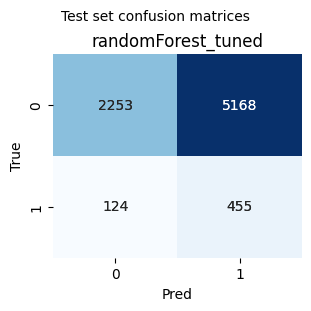

Avoided call duration: 162.02 hours


In [17]:
## Classifying all level 1 data using level 1 model
best_params_RF = {'n_estimators': 180, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 9, 'criterion': 'entropy', 'max_features': None, 'min_impurity_decrease': 0.027572682763323666, 'max_leaf_nodes': 73, 'min_weight_fraction_leaf': 0.06186505322810054}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
model_level1 = RandomForestClassifier(**best_params_RF, class_weight='balanced', random_state=seed)
smote = SMOTE(random_state=seed, sampling_strategy=0.35)
resample_level1 = SMOTEENN(smote=smote, enn=EditedNearestNeighbours(sampling_strategy='majority', n_neighbors=5))

steps = [('r', resample_level1),('m', model_level1)]

pipeline = Pipeline(steps=steps)

pipeline.fit(X_train, y_train)

# Make predictions
#y_pred_level1 = pipeline.predict(X)
y_pred_level1 = pipeline.predict(X_test)


cm = confusion_matrix(y_test, y_pred_level1)
fig, ax = plt.subplots(1, 1, figsize=(3* 1, 3), constrained_layout=True)

for idx, (clf_name, clf) in enumerate(classifiers.items()):
    s = sns.heatmap(cm, ax=ax, cbar=False, annot=True, fmt='g', cmap='Blues')
    s.set_xlabel('Pred')
    s.set_ylabel('True')
    s.set_title(clf_name)
fig.suptitle('Test set confusion matrices', fontsize=10)
plt.show()

# Calculate the amount of call duration avoided
# Duration of calls made to customers predicted as 'no' (0) by Level 1
df['y_pred_level1'] = np.nan  # Add a new column
df.loc[X_test.index, 'y_pred_level1'] = y_pred_level1
#avoided_duration_level1 = (df[y_pred_level1==0]['duration'].sum())/3600
avoided_duration_level1 = df[df['y_pred_level1'] == 0]['duration'].sum()/3600
print(f'Avoided call duration: {avoided_duration_level1:.2f} hours')

df = df.drop(columns=["y_pred_level1"])

Performance on the test: 
           Model  Accuracy  Balanced Accuracy  Recall  Precision  F1 Score  AUC PR
0  LGBM_weighted      0.92               0.86    0.78       0.48      0.60    0.39


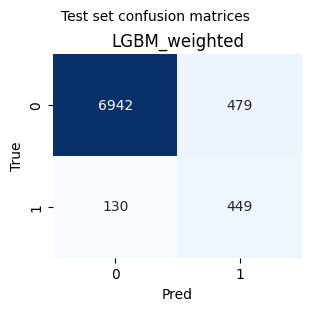

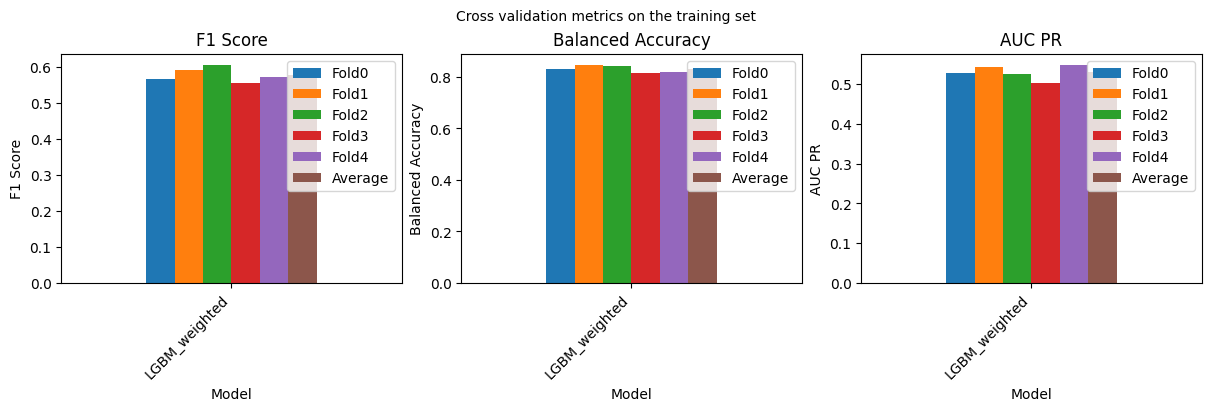

In [49]:
## Best level 2 model
best_params_model2 = study_lgbm.best_params
smote = SMOTE(random_state=seed, sampling_strategy=0.25)
resample_level2 = SMOTEENN(smote=smote, enn=EditedNearestNeighbours(sampling_strategy='majority')) #, n_neighbors=5
neg_count = np.sum(y_train2 == 0)
pos_count = np.sum(y_train2 == 1)
initial_weight = neg_count / pos_count
preprocessing = [] #[('r', resample_level2)]

#model = LinearSVC(random_state=seed, class_weight='balanced')
classifiers = {'LGBM_weighted': LGBMClassifier(**best_params_model2, random_state=seed, verbose=-1)} #scale_pos_weight=initial_weight,

cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm = evaluate_models(
    classifiers, X_train2, y_train2, X_test2, y_test2, preprocessing=preprocessing, seed=seed)

plot_cross_val_metrics(classifiers, cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm)

In [ ]:
df_model2['y_pred_level1'] = np.nan  # Add a new column
print(df_model2.columns)
df_model2.loc[X_test.index, 'y_pred_level1'] = y_pred_level1
print(df_model2['y_pred_level1'].sum())
filtered_calls = df_model2[df_model2['y_pred_level1']==1]
filtered_calls.shape

X_filtered2 = X_test2[y_pred_level1==1]
y_filtered2 = y_test2[y_pred_level1==1]

Index(['age', 'default', 'balance', 'housing', 'loan', 'day', 'duration', 'campaign', 'y', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_married', 'marital_single', 'education_secondary', 'education_tertiary', 'education_unknown', 'contact_telephone', 'contact_unknown', 'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'y_pred_level1'], dtype='object')
5623.0


Performance on the test: 
           Model  Accuracy  Balanced Accuracy  Recall  Precision  F1 Score  AUC PR
0  LGBM_weighted      0.92               0.86    0.80       0.49      0.61    0.41


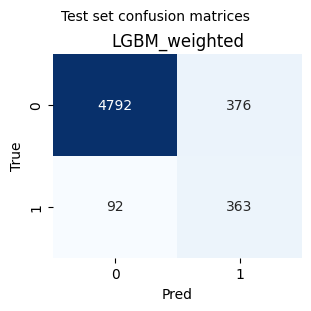

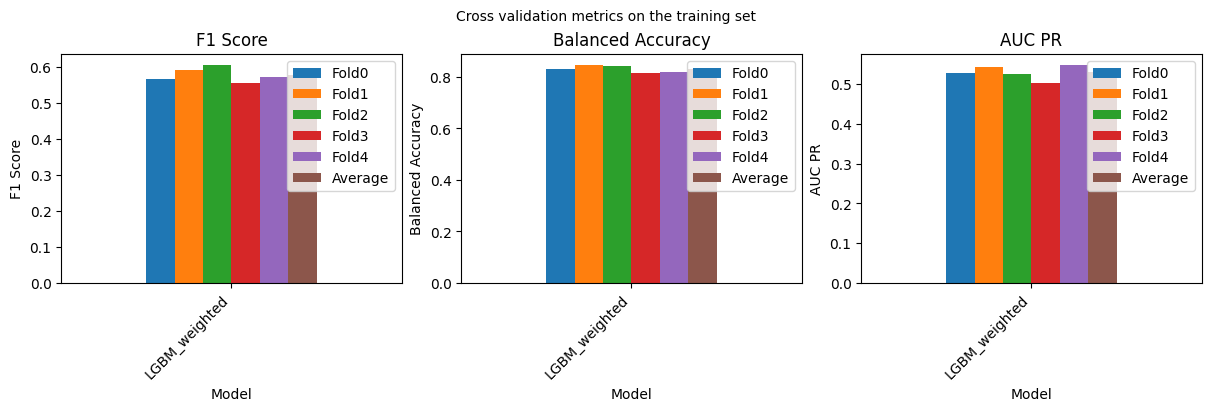

In [57]:
# Initialize StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
model_level2 = LGBMClassifier(random_state=seed, scale_pos_weight=initial_weight*0.02, verbose=-1)
smote = SMOTE(random_state=seed, sampling_strategy=0.25)
resample_level2 = SMOTEENN(smote=smote, enn=EditedNearestNeighbours(sampling_strategy='majority')) #, n_neighbors=5
preprocessing = []#[('r', resample_level2)]
steps = [('r', resample_level2),('m', model_level2)]

# pipeline = Pipeline(steps=steps)

# pipeline.fit(X_train2, y_train2)

# # Make predictions
# y_pred_level2 = pipeline.predict(X_filtered)

classifiers = {'LGBM_weighted': LGBMClassifier(**best_params_model2, random_state=seed, verbose=-1)} #scale_pos_weight=initial_weight*0.005,
   
cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm = evaluate_models(
    classifiers, X_train2, y_train2, X_filtered2, y_filtered2, preprocessing=preprocessing, seed=seed)

plot_cross_val_metrics(classifiers, cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm)


### Tuning prediction threshold

This should be done after feature selection and hyperparameter tuning

Since we are more interested in class1, a threshold of 0.5 may not be optimal because class 1 is the minority class and the signal given out by class 1 may be small.

Use this: https://stats.stackexchange.com/questions/312119/reduce-classification-probability-threshold/312124#312124
